In [1]:
# -*- coding: utf-8 -*-

"""
NEURAL NETWORKS AND DEEP LEARNING

ICT FOR LIFE AND HEALTH - Department of Information Engineering
PHYSICS OF DATA - Department of Physics and Astronomy
COGNITIVE NEUROSCIENCE AND CLINICAL NEUROPSYCHOLOGY - Department of Psychology

A.A. 2019/20 (6 CFU)
Dr. Alberto Testolin, Dr. Federico Chiariotti

Author: Dr. Matteo Gadaleta
Exercise author/modifier: Tommaso Tabarelli

Lab. 02 - Linear regression with artificial neurons
 
"""


#%% Define the true model and generate some noisy samples

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Set random seed
np.random.seed(3)

# Opening data file

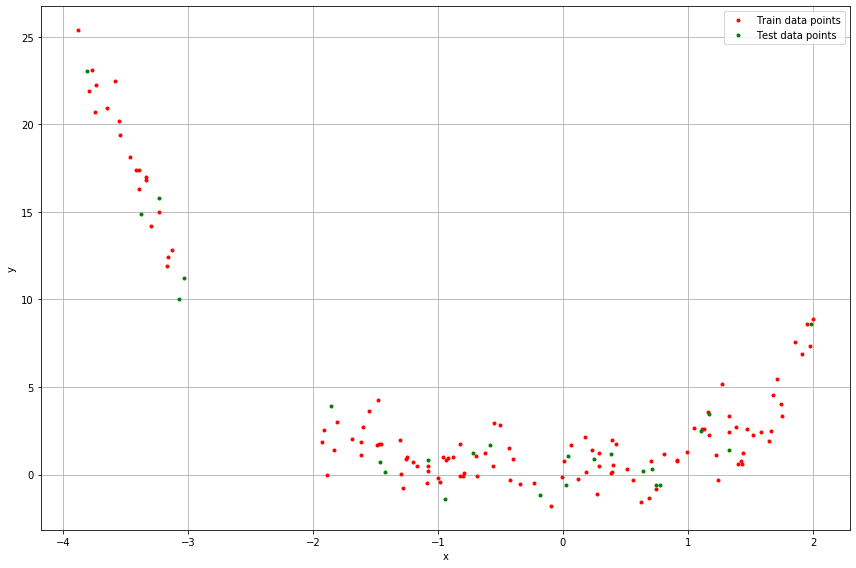

In [2]:
### Open training file
data_train = pd.read_csv("training_set.txt", header=None).values
x_train = data_train[:,0]
y_train = data_train[:,1]

### Open test file
data_test = pd.read_csv("test_set.txt", header=None).values
x_test = data_test[:,0]
y_test = data_test[:,1]

### Plot
plt.close('all')
plt.figure(figsize=(12,8))
x_highres = np.linspace(-4,3,1001)
plt.plot(x_train, y_train, color='r', ls='', marker='.', label='Train data points')
plt.plot(x_test, y_test, color='g', ls='', marker='.', label='Test data points')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

### Preparing X-validation

Doing 6-fold cross validation (arbitrary).

In [3]:
# Shuffling train
data = np.random.shuffle(data_train)

x_train = data_train[:,0]
y_train = data_train[:,1]

In [4]:
# Splitting train test
tot = len(x_train)
mask = np.array(np.ones(tot), "bool")

# Creating a list of train-validation
x_train_sets = []
x_valid_sets = []
y_train_sets = []
y_valid_sets = []

# Splitting into 6 pieces
k_ = 6

for j in range(k_):
    # modifying mask
    temp_mask = mask.copy()
    temp_mask[(j*int(np.round(tot/k_))):((j+1)*int(np.round(tot/k_)))] = False
    x_train_sets.append(x_train[temp_mask])
    x_valid_sets.append(x_train[~temp_mask])
    y_train_sets.append(y_train[temp_mask])
    y_valid_sets.append(y_train[~temp_mask])

# Defining activation functions

### Activation function: sigmoid

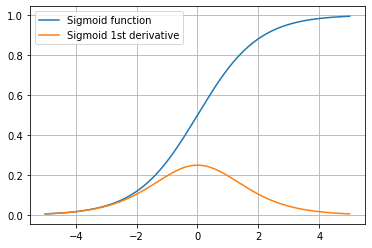

In [5]:
#%% Activation function

# Define activation function: SIGMOID
from scipy.special import expit
sigmoid = expit
# 1st derivative
d_sigmoid = lambda x: sigmoid(x) * (1 - sigmoid(x))

# Plot activation function
x_plot = np.linspace(-5,5,1000)
y_act = sigmoid(x_plot)
y_act_der = d_sigmoid(x_plot)

plt.close('all')
plt.plot(x_plot, y_act, label='Sigmoid function')
plt.plot(x_plot, y_act_der, label='Sigmoid 1st derivative')
plt.legend()
plt.grid()
plt.show()

### Activation function: ReLU

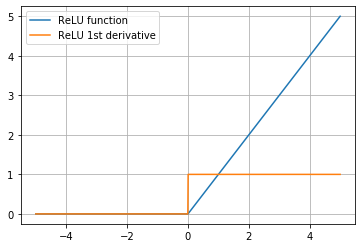

In [6]:
#%% Activation function

# Define activation function: RELU
def ReLU(x):
    x1 = np.array(x)
    x1[x1<0] = 0
    return x1

# 1st derivative
def d_ReLU(x):
    x1 = np.array(x)
    x1[x1>=0] = 1
    x1[x1<0] = 0
    return x1

# Plot activation function
x_plot = np.linspace(-5,5,1000)
y_act = ReLU(x_plot)
y_act_der = d_ReLU(x_plot)

plt.close('all')
plt.plot(x_plot, y_act, label='ReLU function')
plt.plot(x_plot, y_act_der, label='ReLU 1st derivative')
plt.legend()
plt.grid()
plt.show()

### Activation function: ELU

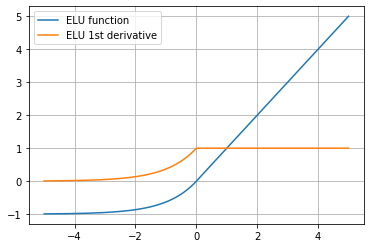

In [7]:
#%% Activation function

# Define activation function: RELU
def ELU(x, alpha=1):
    x1 = np.array(x)
    x1[x1<0] = alpha*(np.exp(x1[x1<0]) - 1)
    return x1

# 1st derivative
def d_ELU(x, alpha=1):
    x1 = np.array(x)
    x1[x1>=0] = 1
    x1[x1<0] = alpha*np.exp(x1[x1<0])
    return x1

# Plot activation function
x_plot = np.linspace(-5,5,1000)
y_act = ELU(x_plot)
y_act_der = d_ELU(x_plot)

plt.close('all')
plt.plot(x_plot, y_act, label='ELU function')
plt.plot(x_plot, y_act_der, label='ELU 1st derivative')
plt.legend()
plt.grid()
plt.show()

# Network class

I have slightly modified the existing class and I have defined another which include the regularization terms.

In [8]:
#%% Network class

class Network():
    
    def __init__(self, Ni, Nh1, Nh2, No, act_func, d_act_func):
            
        ### WEIGHT INITIALIZATION (Xavier)
        # Initialize hidden weights and biases (layer 1)
        Wh1 = (np.random.rand(Nh1, Ni) - 0.5) * np.sqrt(12 / (Nh1 + Ni))
        Bh1 = np.zeros([Nh1, 1])
        self.WBh1 = np.concatenate([Wh1, Bh1], 1) # Weight matrix including biases
        # Initialize hidden weights and biases (layer 2)
        Wh2 = (np.random.rand(Nh2, Nh1) - 0.5) * np.sqrt(12 / (Nh2 + Nh1))
        Bh2 = np.zeros([Nh2, 1])
        self.WBh2 = np.concatenate([Wh2, Bh2], 1) # Weight matrix including biases
        # Initialize output weights and biases
        Wo = (np.random.rand(No, Nh2) - 0.5) * np.sqrt(12 / (No + Nh2))
        Bo = np.zeros([No, 1])
        self.WBo = np.concatenate([Wo, Bo], 1) # Weight matrix including biases
        
        ### ACTIVATION FUNCTION
        self.act = act_func
        self.act_der = d_act_func
        
    # Function to make prediction
    def forward(self, x, additional_out=False):
        
        # Convert to numpy array
        x = np.array(x)
        
        ### Hidden layer 1
        # Add bias term
        X = np.append(x, 1)
        # Forward pass (linear)
        H1 = np.matmul(self.WBh1, X)
        # Activation function
        Z1 = self.act(H1)
        
        ### Hidden layer 2
        # Add bias term
        Z1 = np.append(Z1, 1)
        # Forward pass (linear)
        H2 = np.matmul(self.WBh2, Z1)
        # Activation function
        Z2 = self.act(H2)
        
        ### Output layer
        # Add bias term
        Z2 = np.append(Z2, 1)
        # Forward pass (linear)
        Y = np.matmul(self.WBo, Z2)
        # NO activation function
        
        if additional_out:
            return Y.squeeze(), Z2
        
        return Y.squeeze()
        
    def update(self, x, label, lr):
        
        # Convert to numpy array
        X = np.array(x)
        
        ### Hidden layer 1
        # Add bias term
        X = np.append(X, 1)
        # Forward pass (linear)
        H1 = np.matmul(self.WBh1, X)
        # Activation function
        Z1 = self.act(H1)
        
        ### Hidden layer 2
        # Add bias term
        Z1 = np.append(Z1, 1)
        # Forward pass (linear)
        H2 = np.matmul(self.WBh2, Z1)
        # Activation function
        Z2 = self.act(H2)
        
        ### Output layer
        # Add bias term
        Z2 = np.append(Z2, 1)
        # Forward pass (linear)
        Y = np.matmul(self.WBo, Z2)
        # NO activation function
        
        # Evaluate the derivative terms
        D1 = Y - label
        # Adding L2 regularization (alpha=1/2, so when differentiating there is a "1" factor)
        # Need the norm of the wheghts
        #D1 = Y - label + np.norm(WBo[:,:-1])
        D2 = Z2
        D3 = self.WBo[:,:-1]
        D4 = self.act_der(H2)
        D5 = Z1
        D6 = self.WBh2[:,:-1]
        D7 = self.act_der(H1)
        D8 = X
        
        # Layer Error
        Eo = D1
        Eh2 = np.matmul(Eo, D3) * D4
        Eh1 = np.matmul(Eh2, D6) * D7
        

        # Derivative for weight matrices
        dWBo = np.matmul(Eo.reshape(-1,1), D2.reshape(1,-1))
        dWBh2 = np.matmul(Eh2.reshape(-1,1), D5.reshape(1,-1))
        dWBh1 = np.matmul(Eh1.reshape(-1,1), D8.reshape(1,-1))
        
        # Update the weights
        self.WBh1 -= lr * dWBh1
        self.WBh2 -= lr * dWBh2
        self.WBo -= lr * dWBo
        
        # Evaluate loss function
        loss = (Y - label)**2/2
        
        return loss
    
    def plot_weights(self):
    
        fig, axs = plt.subplots(3, 1, figsize=(12,6))
        fig.tight_layout(h_pad=4, w_pad=2)
        axs[0].hist(net.WBh1.flatten(), 20)
        axs[0].set_title("WBh1")
        axs[0].set_xlabel("Weights")
        axs[0].set_ylabel("Counts per bin")
        axs[1].hist(net.WBh2.flatten(), 50)
        axs[1].set_title("WBh2")
        axs[1].set_xlabel("Weights")
        axs[1].set_ylabel("Counts per bin")
        axs[2].hist(net.WBo.flatten(), 20)
        axs[2].set_title("WBo")
        axs[2].set_xlabel("Weights")
        axs[2].set_ylabel("Counts per bin")
        plt.legend()
        plt.grid()
        plt.show()


#%% Network class with regularization

class Network_reg():
    
    def __init__(self, Ni, Nh1, Nh2, No, act_func, d_act_func, reg, lambda_):
            
        ### WEIGHT INITIALIZATION (Xavier)
        # Initialize hidden weights and biases (layer 1)
        Wh1 = (np.random.rand(Nh1, Ni) - 0.5) * np.sqrt(12 / (Nh1 + Ni))
        Bh1 = np.zeros([Nh1, 1])
        self.WBh1 = np.concatenate([Wh1, Bh1], 1) # Weight matrix including biases
        # Initialize hidden weights and biases (layer 2)
        Wh2 = (np.random.rand(Nh2, Nh1) - 0.5) * np.sqrt(12 / (Nh2 + Nh1))
        Bh2 = np.zeros([Nh2, 1])
        self.WBh2 = np.concatenate([Wh2, Bh2], 1) # Weight matrix including biases
        # Initialize output weights and biases
        Wo = (np.random.rand(No, Nh2) - 0.5) * np.sqrt(12 / (No + Nh2))
        Bo = np.zeros([No, 1])
        self.WBo = np.concatenate([Wo, Bo], 1) # Weight matrix including biases
        
        ### ACTIVATION FUNCTION
        self.act = act_func
        self.act_der = d_act_func
        
        # Regularization
        self.reg = reg
        self.lambda_ = lambda_
        
    # Function to make prediction
    def forward(self, x, additional_out=False):
        
        # Convert to numpy array
        x = np.array(x)
        
        ### Hidden layer 1
        # Add bias term
        X = np.append(x, 1)
        # Forward pass (linear)
        H1 = np.matmul(self.WBh1, X)
        # Activation function
        Z1 = self.act(H1)
        
        ### Hidden layer 2
        # Add bias term
        Z1 = np.append(Z1, 1)
        # Forward pass (linear)
        H2 = np.matmul(self.WBh2, Z1)
        # Activation function
        Z2 = self.act(H2)
        
        ### Output layer
        # Add bias term
        Z2 = np.append(Z2, 1)
        # Forward pass (linear)
        Y = np.matmul(self.WBo, Z2)
        # NO activation function
        
        if additional_out:
            return Y.squeeze(), Z2
        
        return Y.squeeze()
        
    def update(self, x, label, lr):
        
        # Convert to numpy array
        X = np.array(x)
        
        ### Hidden layer 1
        # Add bias term
        X = np.append(X, 1)
        # Forward pass (linear)
        H1 = np.matmul(self.WBh1, X)
        # Activation function
        Z1 = self.act(H1)
        
        ### Hidden layer 2
        # Add bias term
        Z1 = np.append(Z1, 1)
        # Forward pass (linear)
        H2 = np.matmul(self.WBh2, Z1)
        # Activation function
        Z2 = self.act(H2)
        
        ### Output layer
        # Add bias term
        Z2 = np.append(Z2, 1)
        # Forward pass (linear)
        Y = np.matmul(self.WBo, Z2)
        # NO activation function
        
        if (self.reg==""):
            # Evaluate the derivative terms
            D1 = Y - label
            D2 = Z2
            D3 = self.WBo[:,:-1]
            D4 = self.act_der(H2)
            D5 = Z1
            D6 = self.WBh2[:,:-1]
            D7 = self.act_der(H1)
            D8 = X

            # Layer Error
            Eo = D1
            Eh2 = np.matmul(Eo, D3) * D4
            Eh1 = np.matmul(Eh2, D6) * D7
            
            
            # Derivative for weight matrices
            dWBo = np.matmul(Eo.reshape(-1,1), D2.reshape(1,-1)) + WBo
            dWBh2 = np.matmul(Eh2.reshape(-1,1), D5.reshape(1,-1))
            dWBh1 = np.matmul(Eh1.reshape(-1,1), D8.reshape(1,-1))

            # Update the weights
            self.WBh1 -= lr * dWBh1
            self.WBh2 -= lr * dWBh2
            self.WBo -= lr * dWBo

        elif (self.reg=="l2"):
            # Evaluate the derivative terms
            D1 = Y - label
            D2 = Z2
            D3 = self.WBo[:,:-1]
            D4 = self.act_der(H2)
            D5 = Z1
            D6 = self.WBh2[:,:-1]
            D7 = self.act_der(H1)
            D8 = X

            # Layer Error
            Eo = D1
            Eh2 = np.matmul(Eo, D3) * D4
            Eh1 = np.matmul(Eh2, D6) * D7

            # Derivative for weight matrices
            dWBo = np.matmul(Eo.reshape(-1,1), D2.reshape(1,-1)) + 2.*self.lambda_*self.WBo
            dWBh2 = np.matmul(Eh2.reshape(-1,1), D5.reshape(1,-1)) + 2.*self.lambda_*self.WBh2
            dWBh1 = np.matmul(Eh1.reshape(-1,1), D8.reshape(1,-1)) + 2.*self.lambda_*self.WBh1

            # Update the weights
            self.WBh1 -= lr * dWBh1
            self.WBh2 -= lr * dWBh2
            self.WBo -= lr * dWBo
        
        # Evaluate loss function with regularization
        loss = (Y - label)**2/2
        
        return loss
    
    def plot_weights(self):
    
        fig, axs = plt.subplots(3, 1, figsize=(12,6))
        fig.tight_layout(h_pad=4, w_pad=2)
        axs[0].hist(net.WBh1.flatten(), 20)
        axs[0].set_title("WBh1")
        axs[0].set_xlabel("Weights")
        axs[0].set_ylabel("Counts per bin")
        axs[1].hist(net.WBh2.flatten(), 50)
        axs[1].set_title("WBh2")
        axs[1].set_xlabel("Weights")
        axs[1].set_ylabel("Counts per bin")
        axs[2].hist(net.WBo.flatten(), 20)
        axs[2].set_title("WBo")
        axs[2].set_xlabel("Weights")
        axs[2].set_ylabel("Counts per bin")
        plt.legend()
        plt.grid()
        plt.show()

### Comment on regularization loss and weights update

#### Loss:

$$ L = \frac{1}{2}(Y-\hat{Y}) + \lambda \Vert{\beta}\Vert^2 $$

Where here $\beta$ is the vector of ALL weights, thus the concatenation of $W_0$, $W_{h1}$ and $W_{h2}$ flattened. The update rule turns out to be:

$$ \left(\frac{\partial L}{\partial (W_0)_i}\right) = 2\lambda (W_0)_i + \left(\frac{\partial L}{\partial Y} \frac{\partial Y}{\partial W_0}\right)_i $$
$$ \left(\frac{\partial L}{\partial (W_{h1})_i}\right) = 2\lambda (W_{h1})_i + \left(...\right)_i $$
$$ \left(\frac{\partial L}{\partial (W_{h2})_i}\right)_i = 2\lambda (W_{h2})_i + \left(...\right)_i $$

# Training

#### Setting parameters

Max epochs number is fixed to 10000. Min epochs number depends on the network being trained (arbitrary choice fixed while working).

A very simple erly stopping is implemented. After _min_epochs_ epochs have been evaluated, if the error on the validation set increases the train stops immediately, printing and saving the previous error (which is supposed to be the best).

# Starting training

There are some overflow errors dealing with ReLU: I guess they are due to the different learning rate needed...

In [13]:
train_loss_log = []
valid_loss_log = []
test_loss_log = []

#%% TRAINING PARAMETERS
num_epochs = 10000
lr = 0.2
en_decay = True
lr_final = 0.001
lr_decay = (lr_final / lr)**(1 / num_epochs)

### NETWORK PARAMETERS
Ni = 1                     # Number of inputs
Nh1_list = [50, 100, 200]  # Number of hidden neurons (layer 1)
Nh2_list = [50, 100, 200]  # Number of hidden neurons (layer 2)
No = 1                     # Number of outputs

# Possible activation functions are: [sigmoid, ReLU, ELU]
NN_act_f_list = [sigmoid, ReLU, ELU]
NN_d_act_f_list = [d_sigmoid, d_ReLU, ELU]


# BEST PARAMETERS
Nh1_best = 0
Nh2_best = 0
NN_act_f_best = sigmoid
# Initializing the best error (then it is properly handled in tests)
best_error = None

valid_losses = []

# Dictionary to collect all errors
errors_dictio = {}

## Sigmoid

- Min epochs: 2000 (quite slow to train).
- Starting learning rate: 0.2 (it can be kept around this value)


Parameters:
Nh1,Nh2: 50 50
Activation function: expit
Regularizer: l2 	Coefficient: 0.01

Epoch 200 - lr: 0.17989 - Train loss: 5.41037 - Valitation loss: 23.14348
Epoch 400 - lr: 0.16180 - Train loss: 4.93856 - Valitation loss: 19.75254
Epoch 600 - lr: 0.14554 - Train loss: 4.50757 - Valitation loss: 15.96530
Epoch 800 - lr: 0.13090 - Train loss: 4.13000 - Valitation loss: 12.58014
Epoch 1000 - lr: 0.11774 - Train loss: 3.80686 - Valitation loss: 9.84012
Epoch 1200 - lr: 0.10590 - Train loss: 3.53645 - Valitation loss: 7.74645
Epoch 1400 - lr: 0.09525 - Train loss: 3.31696 - Valitation loss: 6.19642
Epoch 1600 - lr: 0.08568 - Train loss: 3.14553 - Valitation loss: 5.06795
Epoch 1800 - lr: 0.07706 - Train loss: 3.01652 - Valitation loss: 4.26240
Epoch 2000 - lr: 0.06931 - Train loss: 2.92141 - Valitation loss: 3.70523
Epoch 2200 - lr: 0.06235 - Train loss: 2.85067 - Valitation loss: 3.33182
Epoch 2400 - lr: 0.05608 - Train loss: 2.79620 - Valitation loss: 3.08420
Epoch 2600 - lr: 0.05

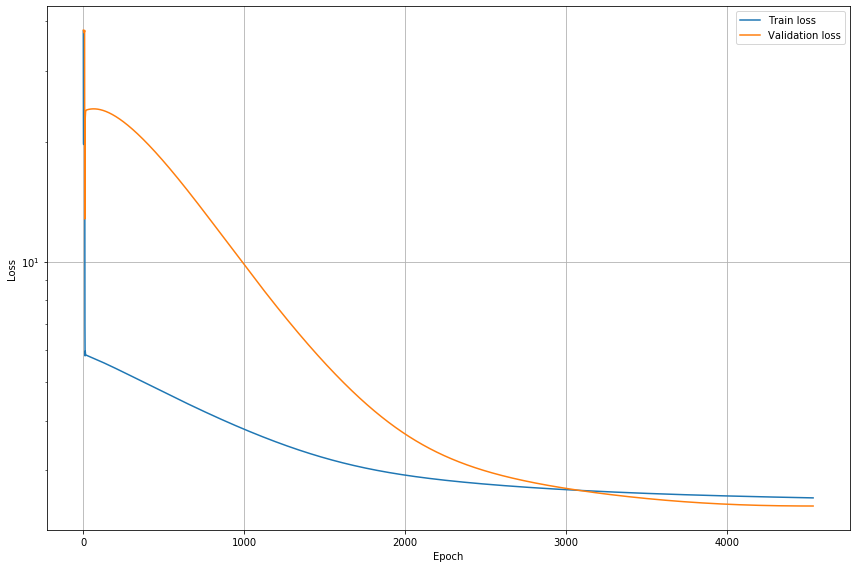

Epoch 200 - lr: 0.17989 - Train loss: 6.57062 - Valitation loss: 9.66821
Epoch 400 - lr: 0.16180 - Train loss: 5.69489 - Valitation loss: 9.38821
Epoch 600 - lr: 0.14554 - Train loss: 5.14034 - Valitation loss: 11.62505
Epoch 800 - lr: 0.13090 - Train loss: 4.72528 - Valitation loss: 7.58263
Epoch 1000 - lr: 0.11774 - Train loss: 4.28100 - Valitation loss: 6.03739
Epoch 1200 - lr: 0.10590 - Train loss: 3.92367 - Valitation loss: 4.84548
Epoch 1400 - lr: 0.09525 - Train loss: 3.63849 - Valitation loss: 3.94567
Epoch 1600 - lr: 0.08568 - Train loss: 3.41438 - Valitation loss: 3.27932
Epoch 1800 - lr: 0.07706 - Train loss: 3.24078 - Valitation loss: 2.79407
Epoch 2000 - lr: 0.06931 - Train loss: 3.08902 - Valitation loss: 2.46988
Epoch 2200 - lr: 0.06235 - Train loss: 2.98392 - Valitation loss: 2.28266
Epoch 2400 - lr: 0.05608 - Train loss: 2.89678 - Valitation loss: 2.16605
Epoch 2600 - lr: 0.05044 - Train loss: 2.69492 - Valitation loss: 1.80454
Epoch 2800 - lr: 0.04537 - Train loss: 2.

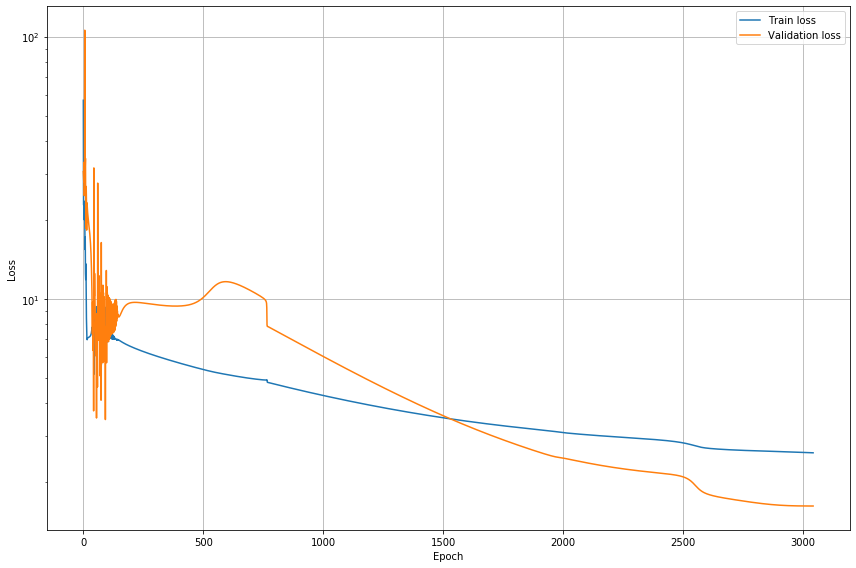

Epoch 200 - lr: 0.17989 - Train loss: 6.43826 - Valitation loss: 42.93901
Epoch 400 - lr: 0.16180 - Train loss: 5.89743 - Valitation loss: 28.67169
Epoch 600 - lr: 0.14554 - Train loss: 5.37140 - Valitation loss: 20.35294
Epoch 800 - lr: 0.13090 - Train loss: 4.88172 - Valitation loss: 13.74927
Epoch 1000 - lr: 0.11774 - Train loss: 4.44851 - Valitation loss: 10.90601
Epoch 1200 - lr: 0.10590 - Train loss: 4.09746 - Valitation loss: 8.81846
Epoch 1400 - lr: 0.09525 - Train loss: 3.81080 - Valitation loss: 7.27556
Epoch 1600 - lr: 0.08568 - Train loss: 3.57675 - Valitation loss: 6.11606
Epoch 1800 - lr: 0.07706 - Train loss: 3.38760 - Valitation loss: 5.22241
Epoch 2000 - lr: 0.06931 - Train loss: 3.23762 - Valitation loss: 4.51498
Epoch 2200 - lr: 0.06235 - Train loss: 3.11838 - Valitation loss: 3.91633
Epoch 2400 - lr: 0.05608 - Train loss: 2.88408 - Valitation loss: 3.08570
Epoch 2600 - lr: 0.05044 - Train loss: 2.83147 - Valitation loss: 2.78689
Epoch 2800 - lr: 0.04537 - Train loss

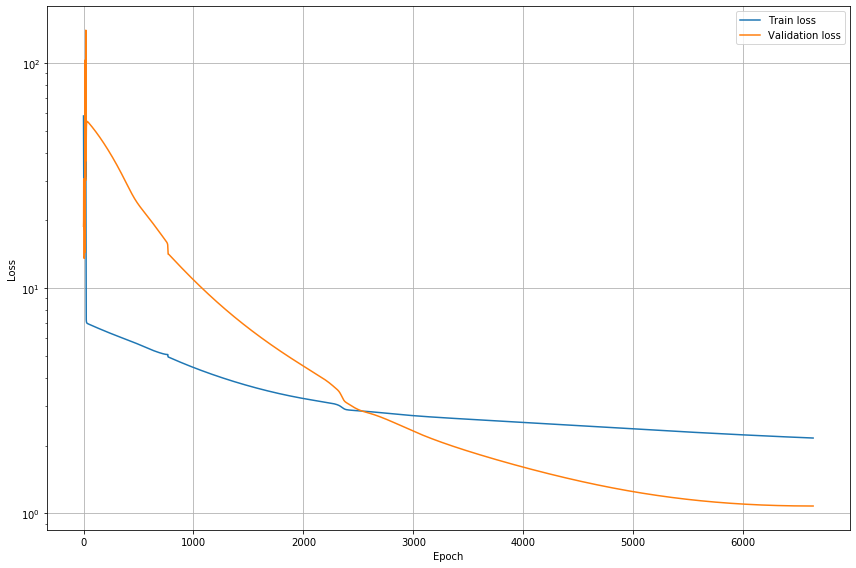

Epoch 200 - lr: 0.17989 - Train loss: 6.33004 - Valitation loss: 11.52851
Epoch 400 - lr: 0.16180 - Train loss: 4.98108 - Valitation loss: 16.60843
Epoch 600 - lr: 0.14554 - Train loss: 4.36994 - Valitation loss: 16.20285
Epoch 800 - lr: 0.13090 - Train loss: 3.89341 - Valitation loss: 16.86361
Epoch 1000 - lr: 0.11774 - Train loss: 3.55105 - Valitation loss: 13.24479
Epoch 1200 - lr: 0.10590 - Train loss: 3.33116 - Valitation loss: 10.50370
Epoch 1400 - lr: 0.09525 - Train loss: 3.06488 - Valitation loss: 8.66103
Epoch 1600 - lr: 0.08568 - Train loss: 2.85389 - Valitation loss: 7.32023
Epoch 1800 - lr: 0.07706 - Train loss: 2.69079 - Valitation loss: 6.37122
Epoch 2000 - lr: 0.06931 - Train loss: 2.56982 - Valitation loss: 5.72051
Epoch 2200 - lr: 0.06235 - Train loss: 2.48421 - Valitation loss: 5.29372
Epoch 2400 - lr: 0.05608 - Train loss: 2.42460 - Valitation loss: 5.02747
Epoch 2600 - lr: 0.05044 - Train loss: 2.38127 - Valitation loss: 4.86598
Epoch 2800 - lr: 0.04537 - Train los

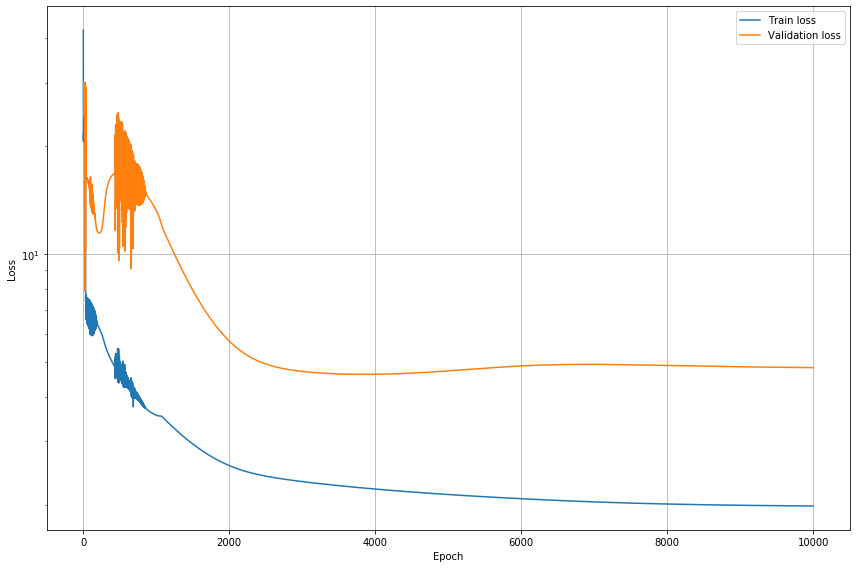

Epoch 200 - lr: 0.17989 - Train loss: 12.76240 - Valitation loss: 14.18895
Epoch 400 - lr: 0.16180 - Train loss: 11.44241 - Valitation loss: 16.02017
Epoch 600 - lr: 0.14554 - Train loss: 10.00876 - Valitation loss: 17.61422
Epoch 800 - lr: 0.13090 - Train loss: 9.19401 - Valitation loss: 20.39159
Epoch 1000 - lr: 0.11774 - Train loss: 8.52458 - Valitation loss: 22.51575
Epoch 1200 - lr: 0.10590 - Train loss: 7.89636 - Valitation loss: 24.61232
Epoch 1400 - lr: 0.09525 - Train loss: 7.33476 - Valitation loss: 24.91914
Epoch 1600 - lr: 0.08568 - Train loss: 6.83955 - Valitation loss: 23.12207
Epoch 1800 - lr: 0.07706 - Train loss: 3.02617 - Valitation loss: 3.98312
Epoch 2000 - lr: 0.06931 - Train loss: 2.86460 - Valitation loss: 3.53857
Epoch 2200 - lr: 0.06235 - Train loss: 2.73217 - Valitation loss: 3.20008
Epoch 2400 - lr: 0.05608 - Train loss: 2.62268 - Valitation loss: 2.94529
Epoch 2600 - lr: 0.05044 - Train loss: 2.53046 - Valitation loss: 2.75218
Epoch 2800 - lr: 0.04537 - Trai

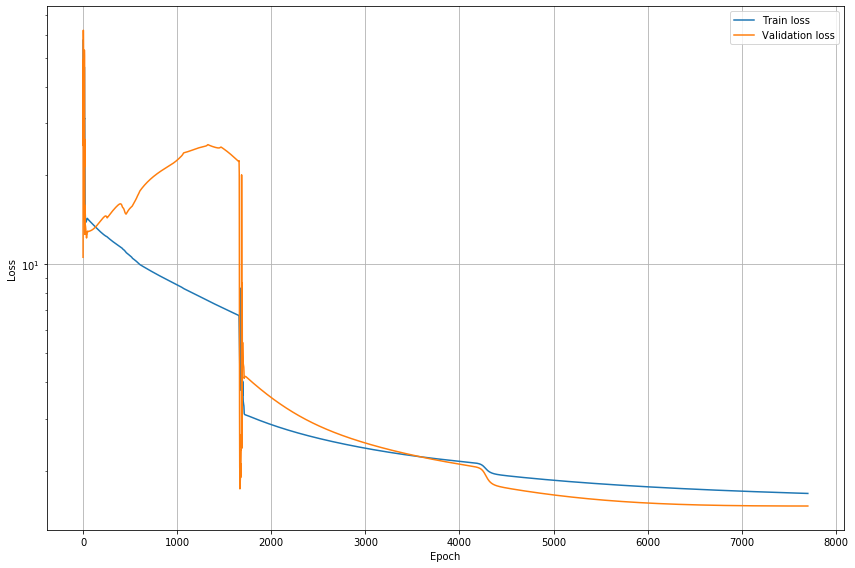

Epoch 200 - lr: 0.17989 - Train loss: 8.51205 - Valitation loss: 3.84362
Epoch 400 - lr: 0.16180 - Train loss: 8.32354 - Valitation loss: 3.65888
Epoch 600 - lr: 0.14554 - Train loss: 7.02253 - Valitation loss: 3.54090
Epoch 800 - lr: 0.13090 - Train loss: 5.96450 - Valitation loss: 3.45145
Epoch 1000 - lr: 0.11774 - Train loss: 5.15720 - Valitation loss: 3.37770
Epoch 1200 - lr: 0.10590 - Train loss: 4.51510 - Valitation loss: 3.30312
Epoch 1400 - lr: 0.09525 - Train loss: 4.01560 - Valitation loss: 3.22383
Epoch 1600 - lr: 0.08568 - Train loss: 3.66628 - Valitation loss: 3.14940
Epoch 1800 - lr: 0.07706 - Train loss: 3.44463 - Valitation loss: 3.07777
Epoch 2000 - lr: 0.06931 - Train loss: 3.31302 - Valitation loss: 2.99612
Epoch 2200 - lr: 0.06235 - Train loss: 3.22773 - Valitation loss: 2.89978
Epoch 2400 - lr: 0.05608 - Train loss: 3.16123 - Valitation loss: 2.79646
Epoch 2600 - lr: 0.05044 - Train loss: 3.10232 - Valitation loss: 2.69429
Epoch 2800 - lr: 0.04537 - Train loss: 3.0

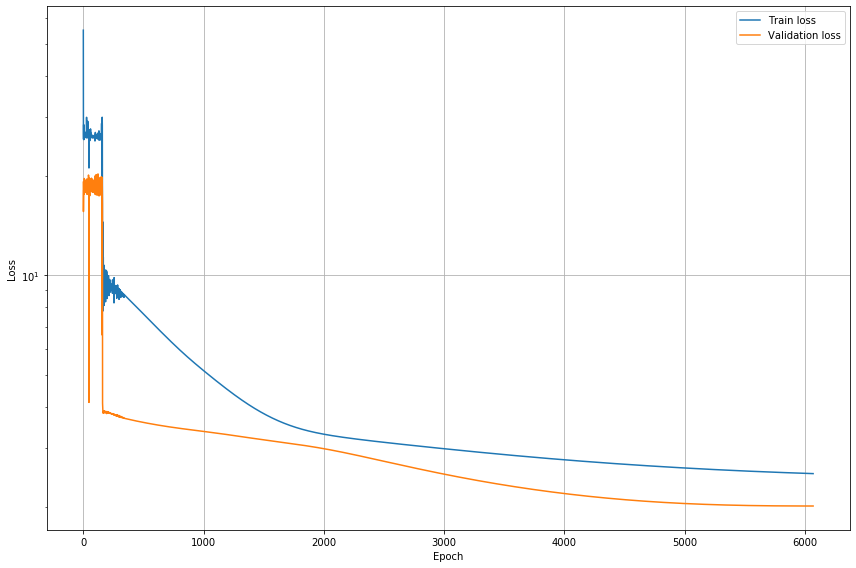


Parameters:
Nh1,Nh2: 100 100
Activation function: expit
Regularizer: l2 	Coefficient: 0.01

Epoch 200 - lr: 0.17989 - Train loss: 5.97164 - Valitation loss: 23.27737
Epoch 400 - lr: 0.16180 - Train loss: 5.51598 - Valitation loss: 18.51570
Epoch 600 - lr: 0.14554 - Train loss: 5.08918 - Valitation loss: 14.61096
Epoch 800 - lr: 0.13090 - Train loss: 4.69067 - Valitation loss: 11.63222
Epoch 1000 - lr: 0.11774 - Train loss: 4.31753 - Valitation loss: 9.34541
Epoch 1200 - lr: 0.10590 - Train loss: 3.97176 - Valitation loss: 7.54296
Epoch 1400 - lr: 0.09525 - Train loss: 3.66343 - Valitation loss: 6.10520
Epoch 1600 - lr: 0.08568 - Train loss: 3.40799 - Valitation loss: 4.98189
Epoch 1800 - lr: 0.07706 - Train loss: 3.21484 - Valitation loss: 4.15156
Epoch 2000 - lr: 0.06931 - Train loss: 3.07770 - Valitation loss: 3.57601
Epoch 2200 - lr: 0.06235 - Train loss: 2.98083 - Valitation loss: 3.19150
Epoch 2400 - lr: 0.05608 - Train loss: 2.91005 - Valitation loss: 2.93320
Epoch 2600 - lr: 0.

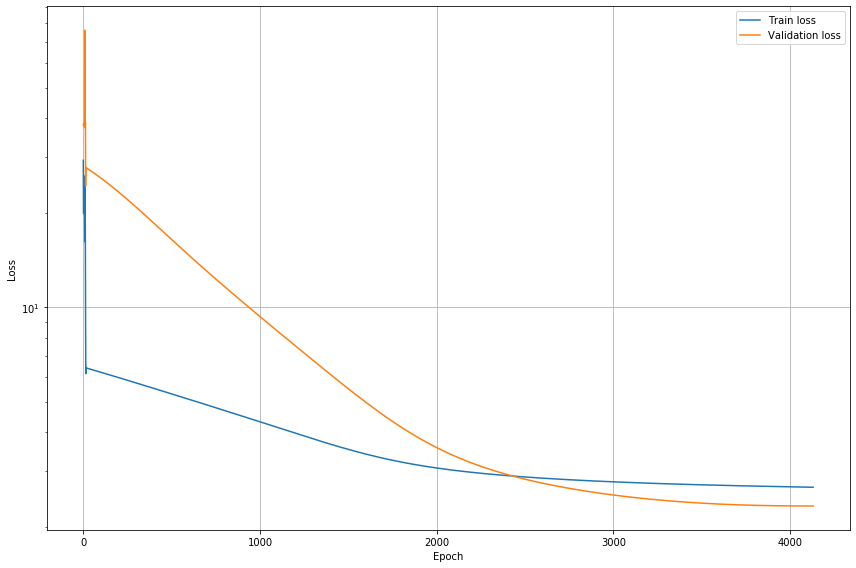

Epoch 200 - lr: 0.17989 - Train loss: 7.18950 - Valitation loss: 12.98154
Epoch 400 - lr: 0.16180 - Train loss: 6.50465 - Valitation loss: 10.37050
Epoch 600 - lr: 0.14554 - Train loss: 5.86788 - Valitation loss: 8.36881
Epoch 800 - lr: 0.13090 - Train loss: 5.27827 - Valitation loss: 6.78455
Epoch 1000 - lr: 0.11774 - Train loss: 4.74983 - Valitation loss: 5.53906
Epoch 1200 - lr: 0.10590 - Train loss: 4.29029 - Valitation loss: 4.56317
Epoch 1400 - lr: 0.09525 - Train loss: 3.90812 - Valitation loss: 3.79584
Epoch 1600 - lr: 0.08568 - Train loss: 3.61376 - Valitation loss: 3.21164
Epoch 1800 - lr: 0.07706 - Train loss: 3.40306 - Valitation loss: 2.79500
Epoch 2000 - lr: 0.06931 - Train loss: 3.25706 - Valitation loss: 2.51313
Epoch 2200 - lr: 0.06235 - Train loss: 3.15493 - Valitation loss: 2.32544
Epoch 2400 - lr: 0.05608 - Train loss: 3.08117 - Valitation loss: 2.19796
Epoch 2600 - lr: 0.05044 - Train loss: 3.02594 - Valitation loss: 2.10756
Epoch 2800 - lr: 0.04537 - Train loss: 2

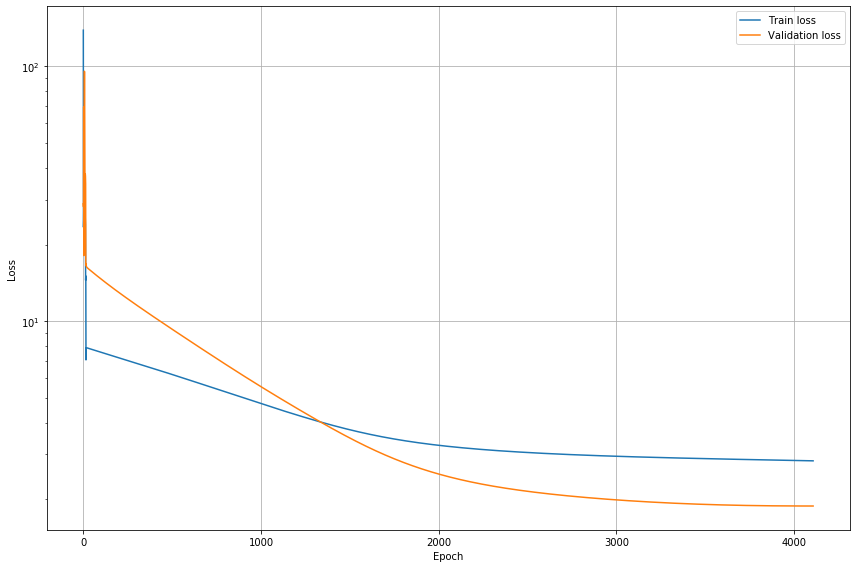

Epoch 200 - lr: 0.17989 - Train loss: 7.23479 - Valitation loss: 18.50190
Epoch 400 - lr: 0.16180 - Train loss: 6.53678 - Valitation loss: 15.17296
Epoch 600 - lr: 0.14554 - Train loss: 5.91140 - Valitation loss: 12.54105
Epoch 800 - lr: 0.13090 - Train loss: 5.34667 - Valitation loss: 10.45156
Epoch 1000 - lr: 0.11774 - Train loss: 4.84301 - Valitation loss: 8.84011
Epoch 1200 - lr: 0.10590 - Train loss: 4.40109 - Valitation loss: 7.59315
Epoch 1400 - lr: 0.09525 - Train loss: 4.02627 - Valitation loss: 6.58431
Epoch 1600 - lr: 0.08568 - Train loss: 3.72433 - Valitation loss: 5.74338
Epoch 1800 - lr: 0.07706 - Train loss: 3.49280 - Valitation loss: 5.05093
Epoch 2000 - lr: 0.06931 - Train loss: 3.32256 - Valitation loss: 4.49839
Epoch 2200 - lr: 0.06235 - Train loss: 3.20136 - Valitation loss: 4.06721
Epoch 2400 - lr: 0.05608 - Train loss: 3.11621 - Valitation loss: 3.73031
Epoch 2600 - lr: 0.05044 - Train loss: 3.05578 - Valitation loss: 3.46037
Epoch 2800 - lr: 0.04537 - Train loss:

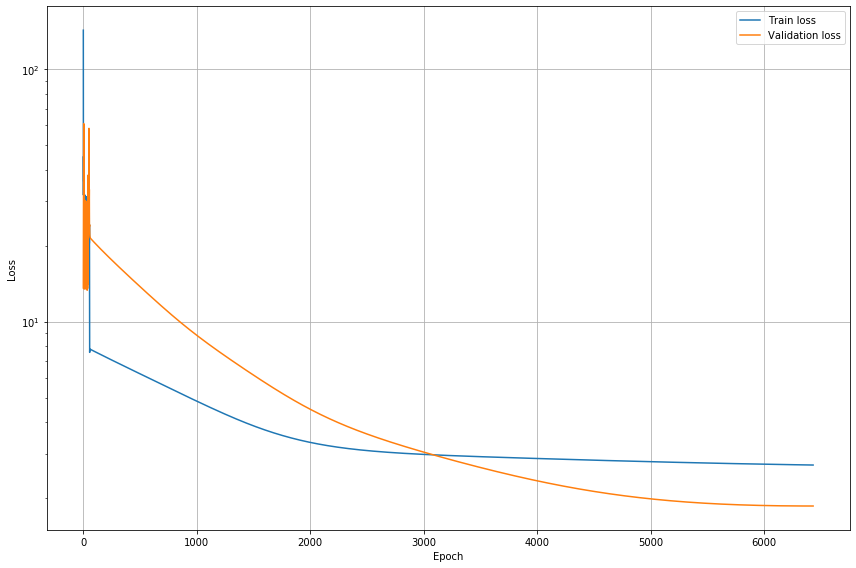

Epoch 200 - lr: 0.17989 - Train loss: 6.14874 - Valitation loss: 27.39098
Epoch 400 - lr: 0.16180 - Train loss: 5.53182 - Valitation loss: 23.79680
Epoch 600 - lr: 0.14554 - Train loss: 5.10917 - Valitation loss: 20.33350
Epoch 800 - lr: 0.13090 - Train loss: 4.87787 - Valitation loss: 15.23804
Epoch 1000 - lr: 0.11774 - Train loss: 4.29238 - Valitation loss: 12.35115
Epoch 1200 - lr: 0.10590 - Train loss: 3.76544 - Valitation loss: 10.16951
Epoch 1400 - lr: 0.09525 - Train loss: 3.32416 - Valitation loss: 8.57450
Epoch 1600 - lr: 0.08568 - Train loss: 2.98386 - Valitation loss: 7.36212
Epoch 1800 - lr: 0.07706 - Train loss: 2.74850 - Valitation loss: 6.45532
Epoch 2000 - lr: 0.06931 - Train loss: 2.59810 - Valitation loss: 5.82734
Epoch 2200 - lr: 0.06235 - Train loss: 2.50336 - Valitation loss: 5.42051
Epoch 2400 - lr: 0.05608 - Train loss: 2.44029 - Valitation loss: 5.16154
Epoch 2600 - lr: 0.05044 - Train loss: 2.39470 - Valitation loss: 4.99343
Epoch 2800 - lr: 0.04537 - Train los

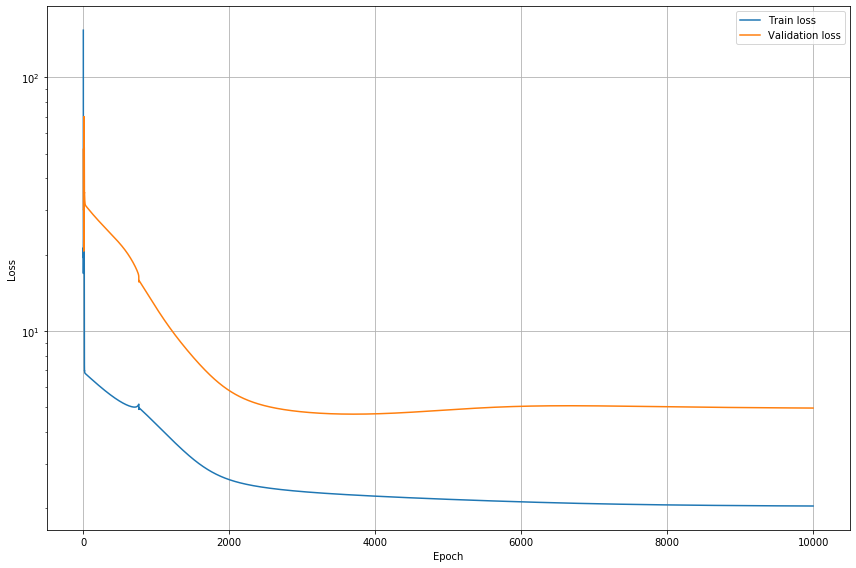

Epoch 200 - lr: 0.17989 - Train loss: 6.12242 - Valitation loss: 15.74600
Epoch 400 - lr: 0.16180 - Train loss: 5.56814 - Valitation loss: 11.79660
Epoch 600 - lr: 0.14554 - Train loss: 5.34184 - Valitation loss: 9.07830
Epoch 800 - lr: 0.13090 - Train loss: 4.98428 - Valitation loss: 6.81967
Epoch 1000 - lr: 0.11774 - Train loss: 4.48249 - Valitation loss: 6.00677
Epoch 1200 - lr: 0.10590 - Train loss: 4.04317 - Valitation loss: 5.35278
Epoch 1400 - lr: 0.09525 - Train loss: 3.68047 - Valitation loss: 4.81317
Epoch 1600 - lr: 0.08568 - Train loss: 3.40586 - Valitation loss: 4.36513
Epoch 1800 - lr: 0.07706 - Train loss: 3.21235 - Valitation loss: 4.00974
Epoch 2000 - lr: 0.06931 - Train loss: 3.07878 - Valitation loss: 3.74119
Epoch 2200 - lr: 0.06235 - Train loss: 2.98321 - Valitation loss: 3.53921
Epoch 2400 - lr: 0.05608 - Train loss: 2.91063 - Valitation loss: 3.38221
Epoch 2600 - lr: 0.05044 - Train loss: 2.85267 - Valitation loss: 3.25474
Epoch 2800 - lr: 0.04537 - Train loss: 2

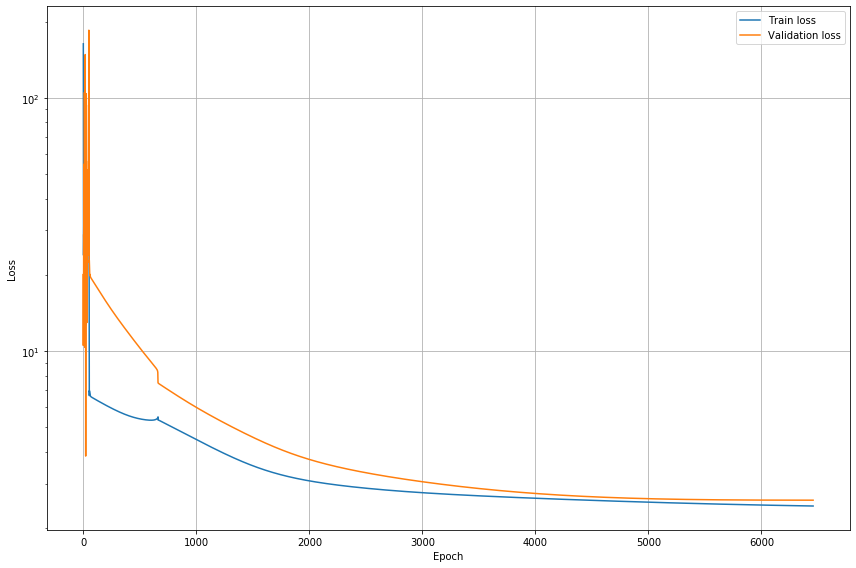

Epoch 200 - lr: 0.17989 - Train loss: 26.33040 - Valitation loss: 17.65516
Epoch 400 - lr: 0.16180 - Train loss: 26.73690 - Valitation loss: 17.81445
Epoch 600 - lr: 0.14554 - Train loss: 26.58627 - Valitation loss: 18.42771
Epoch 800 - lr: 0.13090 - Train loss: 23.61737 - Valitation loss: 16.17029
Epoch 1000 - lr: 0.11774 - Train loss: 22.47910 - Valitation loss: 15.96235
Epoch 1200 - lr: 0.10590 - Train loss: 21.65923 - Valitation loss: 15.07737
Epoch 1400 - lr: 0.09525 - Train loss: 20.92854 - Valitation loss: 14.25523
Epoch 1600 - lr: 0.08568 - Train loss: 20.20696 - Valitation loss: 13.53048
Epoch 1800 - lr: 0.07706 - Train loss: 8.64362 - Valitation loss: 3.96509
Epoch 2000 - lr: 0.06931 - Train loss: 8.01559 - Valitation loss: 3.73664
Epoch 2200 - lr: 0.06235 - Train loss: 7.46374 - Valitation loss: 3.55090
Epoch 2400 - lr: 0.05608 - Train loss: 6.97194 - Valitation loss: 3.39092
Epoch 2600 - lr: 0.05044 - Train loss: 6.53127 - Valitation loss: 3.25115
Epoch 2800 - lr: 0.04537 -

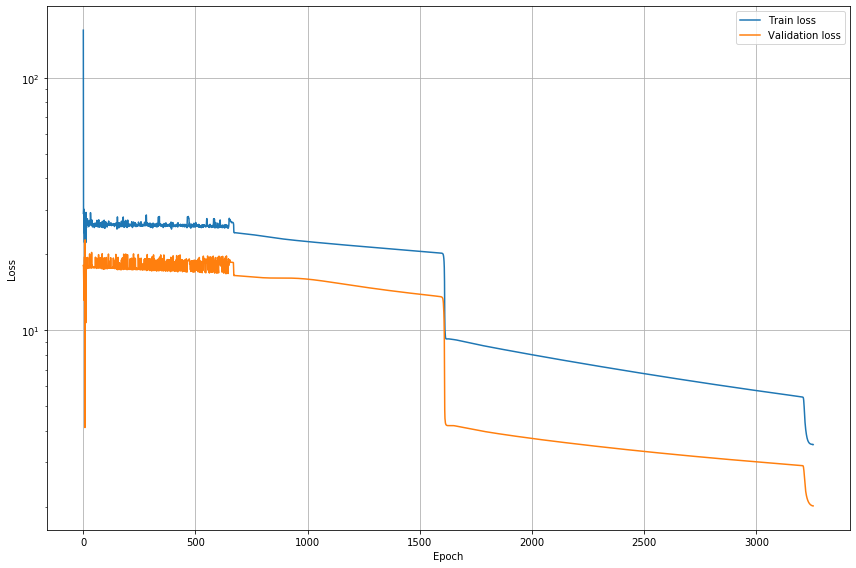


Parameters:
Nh1,Nh2: 200 200
Activation function: expit
Regularizer: l2 	Coefficient: 0.01

Epoch 200 - lr: 0.17989 - Train loss: 18.27078 - Valitation loss: 37.90720
Epoch 400 - lr: 0.16180 - Train loss: 21.11792 - Valitation loss: 38.46760
Epoch 600 - lr: 0.14554 - Train loss: 19.35406 - Valitation loss: 38.65165
Epoch 800 - lr: 0.13090 - Train loss: 19.17973 - Valitation loss: 39.08885
Epoch 1000 - lr: 0.11774 - Train loss: 18.74768 - Valitation loss: 37.75626
Epoch 1200 - lr: 0.10590 - Train loss: 18.45078 - Valitation loss: 36.99387
Epoch 1400 - lr: 0.09525 - Train loss: 18.17211 - Valitation loss: 36.24507
Epoch 1600 - lr: 0.08568 - Train loss: 17.90283 - Valitation loss: 35.52229
Epoch 1800 - lr: 0.07706 - Train loss: 17.64425 - Valitation loss: 34.82935
Epoch 2000 - lr: 0.06931 - Train loss: 17.40061 - Valitation loss: 34.18177
Epoch 2200 - lr: 0.06235 - Train loss: 17.17225 - Valitation loss: 33.58158
Epoch 2400 - lr: 0.05608 - Train loss: 16.95772 - Valitation loss: 33.02424

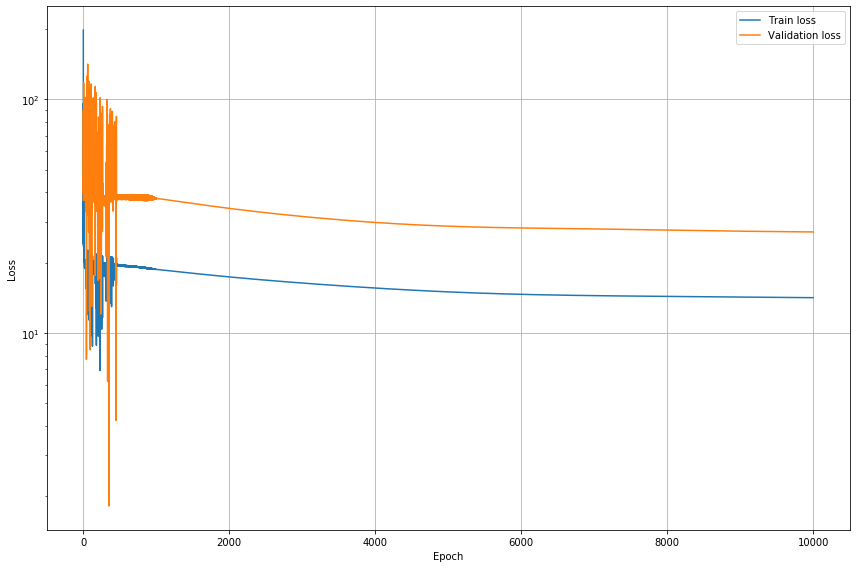

/home/tommaso/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:276: RuntimeWarning: overflow encountered in square
/home/tommaso/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:262: RuntimeWarning: overflow encountered in matmul
/home/tommaso/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:262: RuntimeWarning: invalid value encountered in multiply


Epoch 200 - lr: 0.17989 - Train loss: nan - Valitation loss: nan
Epoch 400 - lr: 0.16180 - Train loss: nan - Valitation loss: nan
Epoch 600 - lr: 0.14554 - Train loss: nan - Valitation loss: nan
Epoch 800 - lr: 0.13090 - Train loss: nan - Valitation loss: nan
Epoch 1000 - lr: 0.11774 - Train loss: nan - Valitation loss: nan
Epoch 1200 - lr: 0.10590 - Train loss: nan - Valitation loss: nan
Epoch 1400 - lr: 0.09525 - Train loss: nan - Valitation loss: nan
Epoch 1600 - lr: 0.08568 - Train loss: nan - Valitation loss: nan
Epoch 1800 - lr: 0.07706 - Train loss: nan - Valitation loss: nan
Epoch 2000 - lr: 0.06931 - Train loss: nan - Valitation loss: nan
Epoch 2200 - lr: 0.06235 - Train loss: nan - Valitation loss: nan
Epoch 2400 - lr: 0.05608 - Train loss: nan - Valitation loss: nan
Epoch 2600 - lr: 0.05044 - Train loss: nan - Valitation loss: nan
Epoch 2800 - lr: 0.04537 - Train loss: nan - Valitation loss: nan
Epoch 3000 - lr: 0.04081 - Train loss: nan - Valitation loss: nan
Epoch 3200 - l

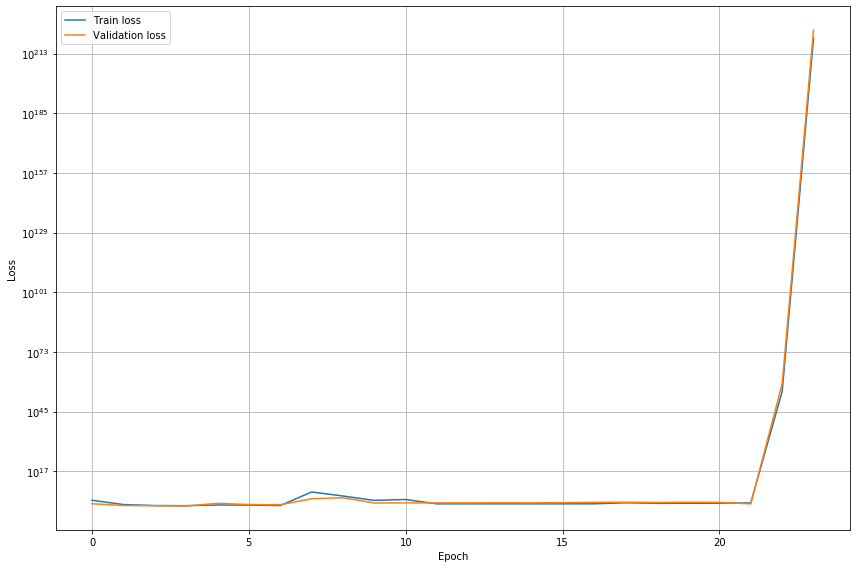

Epoch 200 - lr: 0.17989 - Train loss: 31.04126 - Valitation loss: 26.08924
Epoch 400 - lr: 0.16180 - Train loss: 30.84210 - Valitation loss: 22.65801
Epoch 600 - lr: 0.14554 - Train loss: 29.14305 - Valitation loss: 19.89537
Epoch 800 - lr: 0.13090 - Train loss: 28.74222 - Valitation loss: 11.64497
Epoch 1000 - lr: 0.11774 - Train loss: 26.89728 - Valitation loss: 10.23934
Epoch 1200 - lr: 0.10590 - Train loss: 28.06064 - Valitation loss: 13.81260
Epoch 1400 - lr: 0.09525 - Train loss: 27.52276 - Valitation loss: 13.03251
Epoch 1600 - lr: 0.08568 - Train loss: 23.78076 - Valitation loss: 9.78775
Epoch 1800 - lr: 0.07706 - Train loss: 23.17499 - Valitation loss: 10.57637

EARLY STOPPING:
Epoch 2000 - lr: 0.06931 - Train loss: 22.61469 - Valitation loss: 11.35701



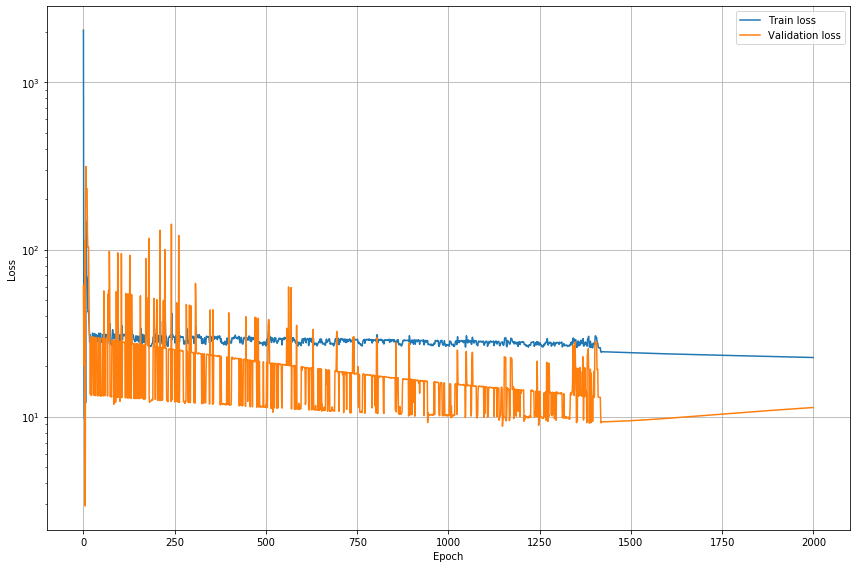

Epoch 200 - lr: 0.17989 - Train loss: 21.66727 - Valitation loss: 30.69032
Epoch 400 - lr: 0.16180 - Train loss: 20.49632 - Valitation loss: 30.98982
Epoch 600 - lr: 0.14554 - Train loss: 19.75058 - Valitation loss: 30.72982
Epoch 800 - lr: 0.13090 - Train loss: 19.56380 - Valitation loss: 30.92844
Epoch 1000 - lr: 0.11774 - Train loss: 19.35146 - Valitation loss: 31.03240
Epoch 1200 - lr: 0.10590 - Train loss: 19.13425 - Valitation loss: 30.97764
Epoch 1400 - lr: 0.09525 - Train loss: 18.91670 - Valitation loss: 30.73930
Epoch 1600 - lr: 0.08568 - Train loss: 18.69438 - Valitation loss: 30.33286
Epoch 1800 - lr: 0.07706 - Train loss: 18.46432 - Valitation loss: 29.79902
Epoch 2000 - lr: 0.06931 - Train loss: 18.22833 - Valitation loss: 29.19288
Epoch 2200 - lr: 0.06235 - Train loss: 17.99103 - Valitation loss: 28.56872
Epoch 2400 - lr: 0.05608 - Train loss: 17.75677 - Valitation loss: 27.96710
Epoch 2600 - lr: 0.05044 - Train loss: 17.52818 - Valitation loss: 27.41180
Epoch 2800 - lr:

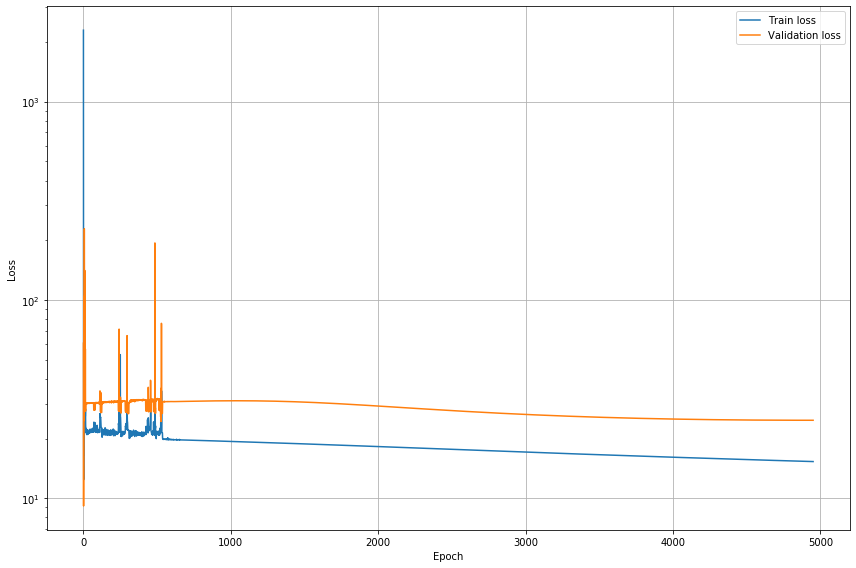

Epoch 200 - lr: 0.17989 - Train loss: 27.76999 - Valitation loss: 10.23678
Epoch 400 - lr: 0.16180 - Train loss: 34.65667 - Valitation loss: 36.91503
Epoch 600 - lr: 0.14554 - Train loss: 32.56771 - Valitation loss: 17.90246
Epoch 800 - lr: 0.13090 - Train loss: 23.81495 - Valitation loss: 10.94813
Epoch 1000 - lr: 0.11774 - Train loss: 23.27616 - Valitation loss: 10.76568
Epoch 1200 - lr: 0.10590 - Train loss: 22.78512 - Valitation loss: 10.69029
Epoch 1400 - lr: 0.09525 - Train loss: 22.34504 - Valitation loss: 10.68330
Epoch 1600 - lr: 0.08568 - Train loss: 21.93355 - Valitation loss: 10.72847
Epoch 1800 - lr: 0.07706 - Train loss: 21.53397 - Valitation loss: 10.81232

EARLY STOPPING:
Epoch 2000 - lr: 0.06931 - Train loss: 21.14482 - Valitation loss: 10.91331



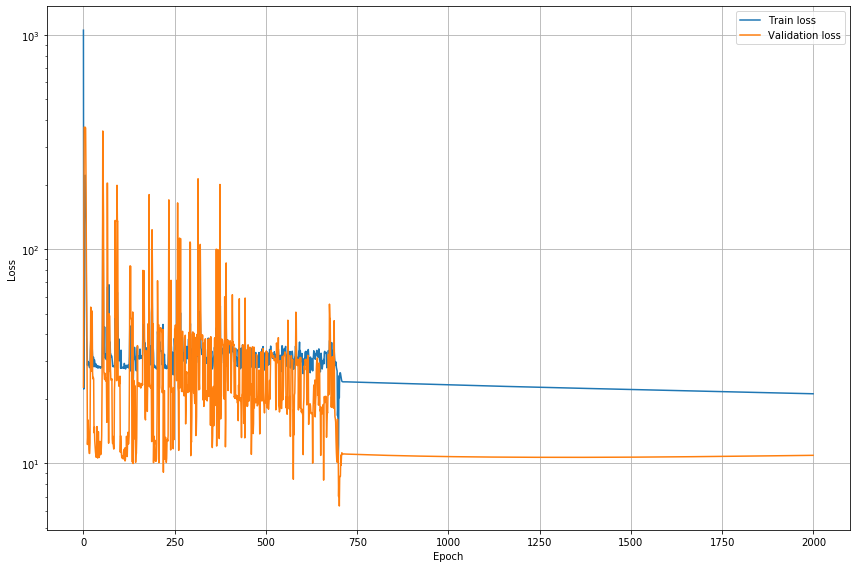

Epoch 200 - lr: 0.17989 - Train loss: 28.20460 - Valitation loss: 17.81576
Epoch 400 - lr: 0.16180 - Train loss: 25.14853 - Valitation loss: 17.54132
Epoch 600 - lr: 0.14554 - Train loss: 24.75950 - Valitation loss: 16.67286
Epoch 800 - lr: 0.13090 - Train loss: 24.22059 - Valitation loss: 16.34955
Epoch 1000 - lr: 0.11774 - Train loss: 23.81336 - Valitation loss: 15.96871
Epoch 1200 - lr: 0.10590 - Train loss: 23.31541 - Valitation loss: 15.51284
Epoch 1400 - lr: 0.09525 - Train loss: 22.72359 - Valitation loss: 15.19170
Epoch 1600 - lr: 0.08568 - Train loss: 22.18675 - Valitation loss: 15.15429
Epoch 1800 - lr: 0.07706 - Train loss: 21.70836 - Valitation loss: 15.04767
Epoch 2000 - lr: 0.06931 - Train loss: 21.27809 - Valitation loss: 14.74813
Epoch 2200 - lr: 0.06235 - Train loss: 20.89097 - Valitation loss: 14.41405
Epoch 2400 - lr: 0.05608 - Train loss: 20.53957 - Valitation loss: 14.11659
Epoch 2600 - lr: 0.05044 - Train loss: 20.21612 - Valitation loss: 13.86298
Epoch 2800 - lr:

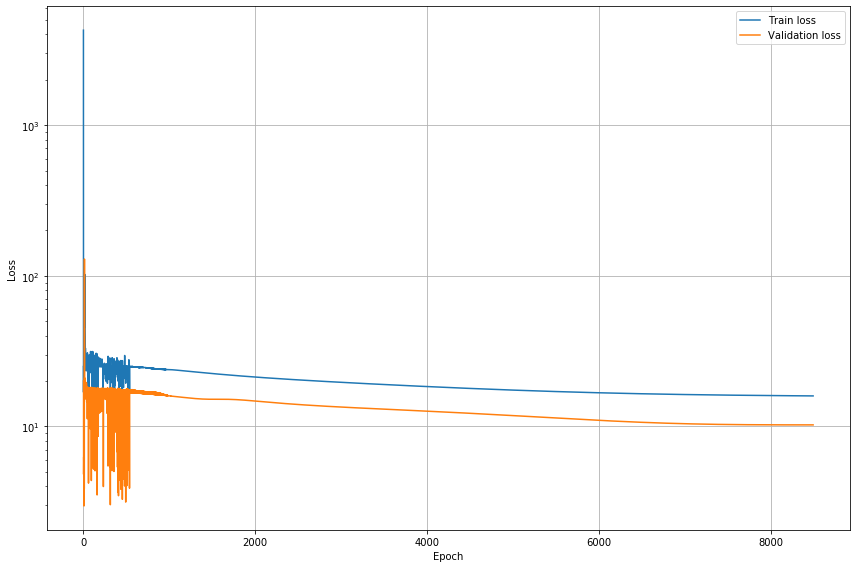

In [15]:
# Doing cross validation

#%% TRAINING PARAMETERS
min_epochs = 2000
num_epochs = 10000
lr = 0.2
en_decay = True
lr_final = 0.001
lr_decay = (lr_final / lr)**(1 / num_epochs)
regul = "l2"
lambda_regul = 0.01

NN_act_f = sigmoid
NN_d_act_f = d_sigmoid

# Conventionally not training on a grid but using same number of neurons
for Nh1,Nh2 in zip(Nh1_list,Nh2_list):

    valid_losses = []

    print("\nParameters:")
    print("Nh1,Nh2:", Nh1, Nh2)
    print("Activation function:", NN_act_f.__name__)
    print("Regularizer:", regul, "\tCoefficient:", lambda_regul, end="\n\n")

    for ind_set in range(len(x_train_sets)):
        # Defining the NN
        #net = Network(Ni, Nh1, Nh2, No, NN_act_f, NN_d_act_f)
        net = Network_reg(Ni, Nh1, Nh2, No, NN_act_f, NN_d_act_f, regul, lambda_regul)

        # Preparing loss lists
        train_loss_log = []
        valid_loss_log = []

        # Refreshing learning rate
        lr = 0.2
        
        # Training NN on k-fold
        for num_ep in range(num_epochs):
            # Learning rate decay
            if en_decay:
                lr *= lr_decay
            # Train single epoch (sample by sample, no batch for now)
            train_loss_vec = [net.update(x, y, lr) for x, y in zip(x_train_sets[ind_set], y_train_sets[ind_set])]
            avg_train_loss = np.mean(train_loss_vec)
            # Test network
            y_valid_est = np.array([net.forward(x) for x in x_valid_sets[ind_set]])
            avg_valid_loss = np.mean((y_valid_est - y_valid_sets[ind_set])**2/2)
            
            # Log (using validation error list for early stopping)
            train_loss_log.append(avg_train_loss)
            valid_loss_log.append(avg_valid_loss)

            # Trying a condition for early stopping
            if ( (len(valid_loss_log)>=min_epochs) and (valid_loss_log[-1]>valid_loss_log[-2]) and valid_loss_log[-1]<2*train_loss_log[-1]):
                print("\nEARLY STOPPING:")
                print('Epoch %d - lr: %.5f - Train loss: %.5f - Valitation loss: %.5f' % (num_ep + 1, lr, avg_train_loss, avg_valid_loss), end="\n\n")
                break

            if (num_ep%200 == 199):
                print('Epoch %d - lr: %.5f - Train loss: %.5f - Valitation loss: %.5f' % (num_ep + 1, lr, avg_train_loss, avg_valid_loss))

        errors_dictio[str(NN_act_f.__name__)+str(Nh1)+str(Nh2)+regul+str(2*lambda_regul)+"valid"+str(ind_set)] = valid_loss_log[-2]
        
        valid_losses.append(valid_loss_log[-2])
        
        # Plot losses
        plt.title(str(str(NN_act_f.__name__)+str(Nh1)+str(Nh2)))
        plt.close('all')
        plt.figure(figsize=(12,8))
        plt.semilogy(train_loss_log, label='Train loss')
        plt.semilogy(valid_loss_log, label='Validation loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid()
        plt.legend()
        plt.tight_layout()
        plt.show()

    temp_val_loss = np.mean(valid_losses)

    if (best_error == None or temp_val_loss < best_error):
        best_error = temp_val_loss
        NN_act_f_best = NN_act_f
        Nh1_best = Nh1
        Nh2_best = Nh2

In [16]:
print(best_error)
print(NN_act_f_best)
print(Nh1_best)
print(Nh2_best)

2.011067222350301
<ufunc 'expit'>
50
50


In [17]:
errors_dictio

{'expit5050l20.02valid0': 2.4444197493056516,
 'expit5050l20.02valid1': 1.620443676598492,
 'expit5050l20.02valid2': 1.0785823462150093,
 'expit5050l20.02valid3': 4.821342904448395,
 'expit5050l20.02valid4': 1.5179142450823804,
 'expit5050l20.02valid5': 2.011067222350301,
 'expit100100l20.02valid0': 2.328962792146696,
 'expit100100l20.02valid1': 1.8813379328318944,
 'expit100100l20.02valid2': 1.8587367564828816,
 'expit100100l20.02valid3': 4.973225424278272,
 'expit100100l20.02valid4': 2.582980478650188,
 'expit100100l20.02valid5': 2.017698511137269,
 'expit200200l20.02valid0': 27.103824752995724,
 'expit200200l20.02valid1': nan,
 'expit200200l20.02valid2': 11.353404424172613,
 'expit200200l20.02valid3': 24.74219685371748,
 'expit200200l20.02valid4': 10.912804711398778,
 'expit200200l20.02valid5': 10.244082583974361}

## ReLU

- Min epocs: 5000 (quite fast to train).
- Starting learning rate: 0.001 (ReLU NN needs smaller learning rate due to their high values of errors on estimations (which are due to the fixed derivative to 1) )


Parameters:
Nh1,Nh2: 50 50
Activation function: ReLU
Regularizer: l2 	Coefficient: 0.01

Epoch 200 - lr: 0.00091 - Train loss: 0.79858 - Valitation loss: 1.24466
Epoch 400 - lr: 0.00083 - Train loss: 0.75766 - Valitation loss: 1.23931
Epoch 600 - lr: 0.00076 - Train loss: 0.74289 - Valitation loss: 1.24561
Epoch 800 - lr: 0.00069 - Train loss: 0.73355 - Valitation loss: 1.25453
Epoch 1000 - lr: 0.00063 - Train loss: 0.72630 - Valitation loss: 1.26476
Epoch 1200 - lr: 0.00058 - Train loss: 0.72083 - Valitation loss: 1.27463
Epoch 1400 - lr: 0.00052 - Train loss: 0.71650 - Valitation loss: 1.28302
Epoch 1600 - lr: 0.00048 - Train loss: 0.71227 - Valitation loss: 1.28979
Epoch 1800 - lr: 0.00044 - Train loss: 0.70564 - Valitation loss: 1.28298
Epoch 2000 - lr: 0.00040 - Train loss: 0.70017 - Valitation loss: 1.27757
Epoch 2200 - lr: 0.00036 - Train loss: 0.69458 - Valitation loss: 1.26816
Epoch 2400 - lr: 0.00033 - Train loss: 0.68890 - Valitation loss: 1.25630
Epoch 2600 - lr: 0.00030 -

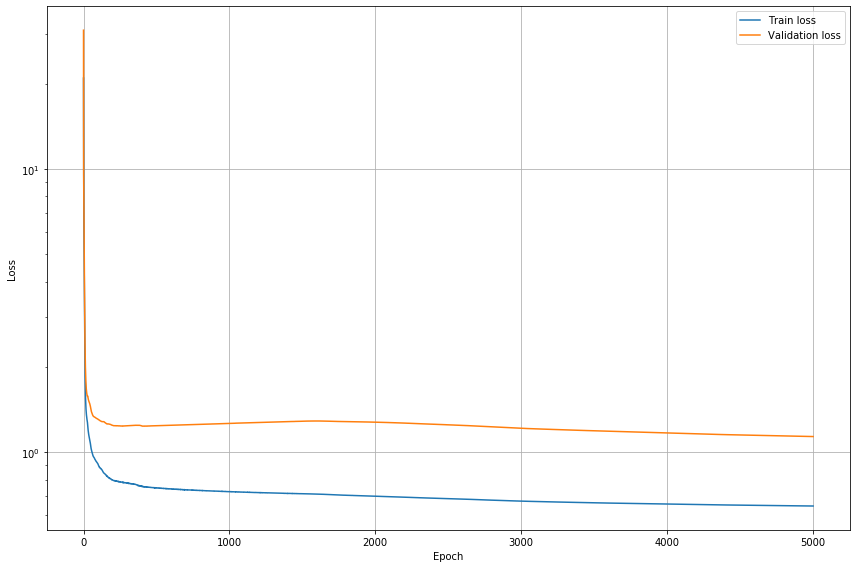

Epoch 200 - lr: 0.00091 - Train loss: 0.91689 - Valitation loss: 0.96961
Epoch 400 - lr: 0.00083 - Train loss: 0.82199 - Valitation loss: 0.93690
Epoch 600 - lr: 0.00076 - Train loss: 0.78008 - Valitation loss: 0.92618
Epoch 800 - lr: 0.00069 - Train loss: 0.74996 - Valitation loss: 0.91896
Epoch 1000 - lr: 0.00063 - Train loss: 0.72784 - Valitation loss: 0.91542
Epoch 1200 - lr: 0.00058 - Train loss: 0.71104 - Valitation loss: 0.91291
Epoch 1400 - lr: 0.00052 - Train loss: 0.69778 - Valitation loss: 0.91102
Epoch 1600 - lr: 0.00048 - Train loss: 0.68641 - Valitation loss: 0.90970
Epoch 1800 - lr: 0.00044 - Train loss: 0.67650 - Valitation loss: 0.90876
Epoch 2000 - lr: 0.00040 - Train loss: 0.66778 - Valitation loss: 0.90836
Epoch 2200 - lr: 0.00036 - Train loss: 0.66026 - Valitation loss: 0.90789
Epoch 2400 - lr: 0.00033 - Train loss: 0.65365 - Valitation loss: 0.90760
Epoch 2600 - lr: 0.00030 - Train loss: 0.64787 - Valitation loss: 0.90747
Epoch 2800 - lr: 0.00028 - Train loss: 0.6

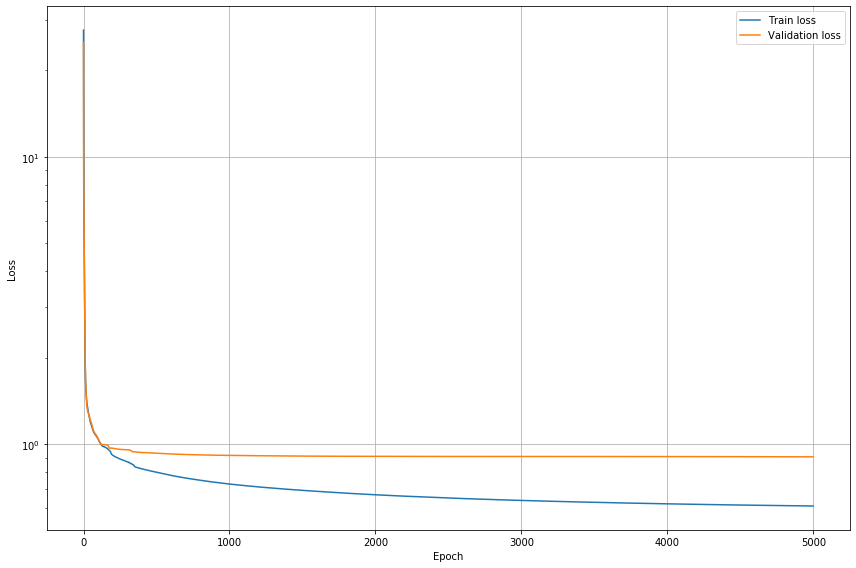

Epoch 200 - lr: 0.00091 - Train loss: 1.11813 - Valitation loss: 1.11499
Epoch 400 - lr: 0.00083 - Train loss: 0.98272 - Valitation loss: 0.90591
Epoch 600 - lr: 0.00076 - Train loss: 0.87488 - Valitation loss: 0.81728
Epoch 800 - lr: 0.00069 - Train loss: 0.81632 - Valitation loss: 0.77920
Epoch 1000 - lr: 0.00063 - Train loss: 0.78418 - Valitation loss: 0.75749
Epoch 1200 - lr: 0.00058 - Train loss: 0.76143 - Valitation loss: 0.74609
Epoch 1400 - lr: 0.00052 - Train loss: 0.74465 - Valitation loss: 0.74386
Epoch 1600 - lr: 0.00048 - Train loss: 0.73085 - Valitation loss: 0.73889
Epoch 1800 - lr: 0.00044 - Train loss: 0.71956 - Valitation loss: 0.73614
Epoch 2000 - lr: 0.00040 - Train loss: 0.70963 - Valitation loss: 0.73298
Epoch 2200 - lr: 0.00036 - Train loss: 0.70080 - Valitation loss: 0.72923
Epoch 2400 - lr: 0.00033 - Train loss: 0.69302 - Valitation loss: 0.72651
Epoch 2600 - lr: 0.00030 - Train loss: 0.68627 - Valitation loss: 0.72625
Epoch 2800 - lr: 0.00028 - Train loss: 0.6

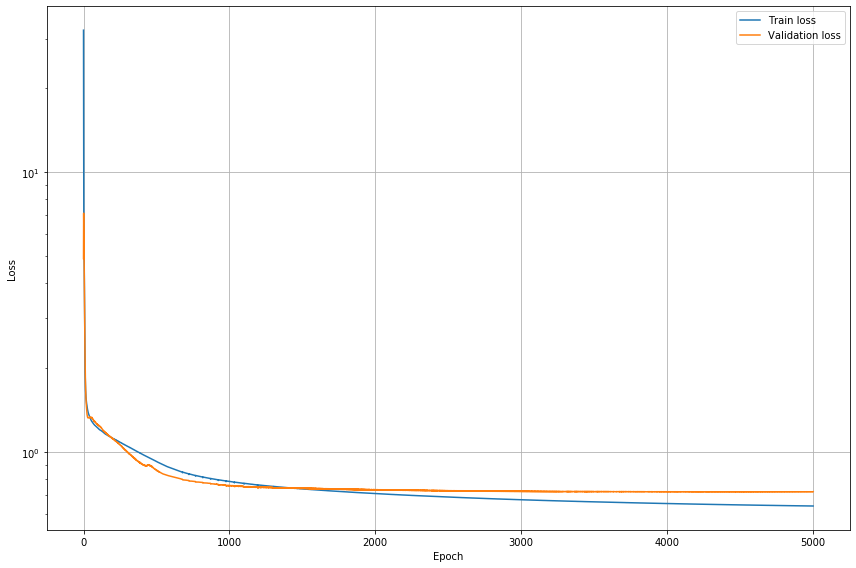

Epoch 200 - lr: 0.00091 - Train loss: 1.04929 - Valitation loss: 0.85864
Epoch 400 - lr: 0.00083 - Train loss: 0.96690 - Valitation loss: 0.69347
Epoch 600 - lr: 0.00076 - Train loss: 0.89824 - Valitation loss: 0.57267
Epoch 800 - lr: 0.00069 - Train loss: 0.85631 - Valitation loss: 0.51129
Epoch 1000 - lr: 0.00063 - Train loss: 0.82977 - Valitation loss: 0.47877
Epoch 1200 - lr: 0.00058 - Train loss: 0.81126 - Valitation loss: 0.46515
Epoch 1400 - lr: 0.00052 - Train loss: 0.79685 - Valitation loss: 0.45365
Epoch 1600 - lr: 0.00048 - Train loss: 0.78479 - Valitation loss: 0.44718
Epoch 1800 - lr: 0.00044 - Train loss: 0.77465 - Valitation loss: 0.44702
Epoch 2000 - lr: 0.00040 - Train loss: 0.76720 - Valitation loss: 0.44452
Epoch 2200 - lr: 0.00036 - Train loss: 0.75985 - Valitation loss: 0.44308
Epoch 2400 - lr: 0.00033 - Train loss: 0.75307 - Valitation loss: 0.44244
Epoch 2600 - lr: 0.00030 - Train loss: 0.74702 - Valitation loss: 0.44242
Epoch 2800 - lr: 0.00028 - Train loss: 0.7

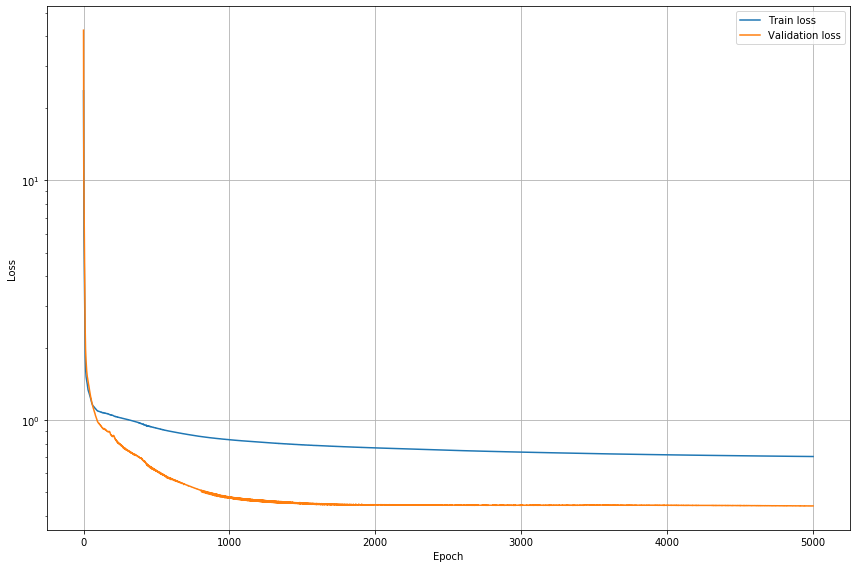

Epoch 200 - lr: 0.00091 - Train loss: 1.00363 - Valitation loss: 1.17837
Epoch 400 - lr: 0.00083 - Train loss: 0.95717 - Valitation loss: 1.07468
Epoch 600 - lr: 0.00076 - Train loss: 0.90479 - Valitation loss: 1.03025
Epoch 800 - lr: 0.00069 - Train loss: 0.87535 - Valitation loss: 1.00327
Epoch 1000 - lr: 0.00063 - Train loss: 0.85183 - Valitation loss: 0.97199
Epoch 1200 - lr: 0.00058 - Train loss: 0.83069 - Valitation loss: 0.93557
Epoch 1400 - lr: 0.00052 - Train loss: 0.81310 - Valitation loss: 0.91298
Epoch 1600 - lr: 0.00048 - Train loss: 0.79709 - Valitation loss: 0.88939
Epoch 1800 - lr: 0.00044 - Train loss: 0.78293 - Valitation loss: 0.86578
Epoch 2000 - lr: 0.00040 - Train loss: 0.77002 - Valitation loss: 0.84496
Epoch 2200 - lr: 0.00036 - Train loss: 0.75906 - Valitation loss: 0.82610
Epoch 2400 - lr: 0.00033 - Train loss: 0.75007 - Valitation loss: 0.81578
Epoch 2600 - lr: 0.00030 - Train loss: 0.74198 - Valitation loss: 0.80839
Epoch 2800 - lr: 0.00028 - Train loss: 0.7

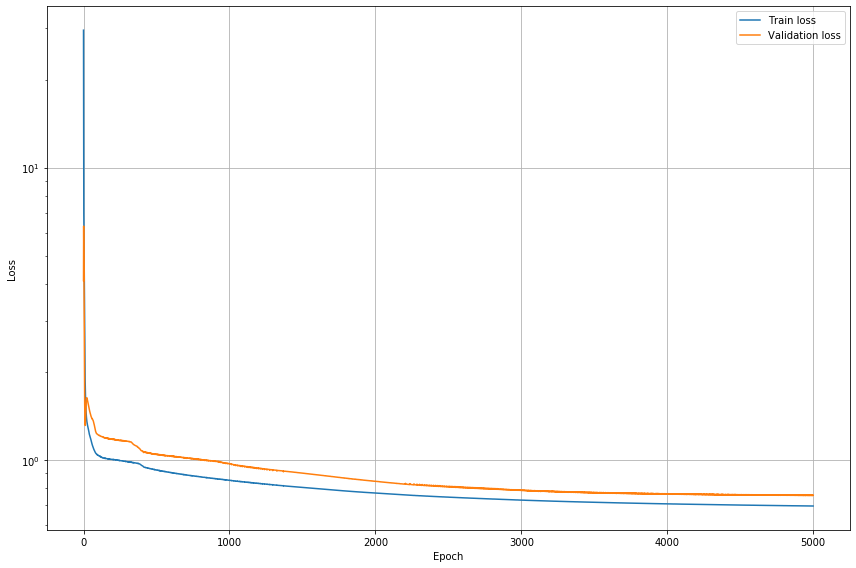

Epoch 200 - lr: 0.00091 - Train loss: 0.98750 - Valitation loss: 0.76061
Epoch 400 - lr: 0.00083 - Train loss: 0.88097 - Valitation loss: 0.71662
Epoch 600 - lr: 0.00076 - Train loss: 0.83915 - Valitation loss: 0.69615
Epoch 800 - lr: 0.00069 - Train loss: 0.81463 - Valitation loss: 0.68552
Epoch 1000 - lr: 0.00063 - Train loss: 0.79492 - Valitation loss: 0.67388
Epoch 1200 - lr: 0.00058 - Train loss: 0.77833 - Valitation loss: 0.66759
Epoch 1400 - lr: 0.00052 - Train loss: 0.76488 - Valitation loss: 0.66217
Epoch 1600 - lr: 0.00048 - Train loss: 0.75186 - Valitation loss: 0.65847
Epoch 1800 - lr: 0.00044 - Train loss: 0.74103 - Valitation loss: 0.65520
Epoch 2000 - lr: 0.00040 - Train loss: 0.73213 - Valitation loss: 0.65204
Epoch 2200 - lr: 0.00036 - Train loss: 0.72430 - Valitation loss: 0.64961
Epoch 2400 - lr: 0.00033 - Train loss: 0.71790 - Valitation loss: 0.64808
Epoch 2600 - lr: 0.00030 - Train loss: 0.71223 - Valitation loss: 0.64661
Epoch 2800 - lr: 0.00028 - Train loss: 0.7

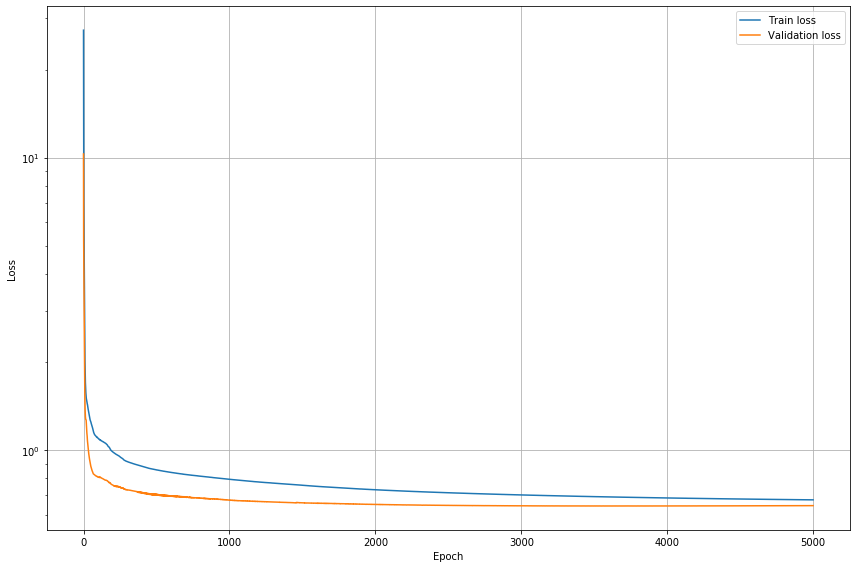


Parameters:
Nh1,Nh2: 100 100
Activation function: ReLU
Regularizer: l2 	Coefficient: 0.01

Epoch 200 - lr: 0.00091 - Train loss: 0.85332 - Valitation loss: 1.29142
Epoch 400 - lr: 0.00083 - Train loss: 0.81898 - Valitation loss: 1.28672
Epoch 600 - lr: 0.00076 - Train loss: 0.79225 - Valitation loss: 1.27161
Epoch 800 - lr: 0.00069 - Train loss: 0.77323 - Valitation loss: 1.27426
Epoch 1000 - lr: 0.00063 - Train loss: 0.75883 - Valitation loss: 1.27677
Epoch 1200 - lr: 0.00058 - Train loss: 0.74357 - Valitation loss: 1.27917
Epoch 1400 - lr: 0.00052 - Train loss: 0.73003 - Valitation loss: 1.27907
Epoch 1600 - lr: 0.00048 - Train loss: 0.71846 - Valitation loss: 1.27268
Epoch 1800 - lr: 0.00044 - Train loss: 0.70900 - Valitation loss: 1.26499
Epoch 2000 - lr: 0.00040 - Train loss: 0.70023 - Valitation loss: 1.25550
Epoch 2200 - lr: 0.00036 - Train loss: 0.69210 - Valitation loss: 1.24345
Epoch 2400 - lr: 0.00033 - Train loss: 0.68414 - Valitation loss: 1.22892
Epoch 2600 - lr: 0.00030

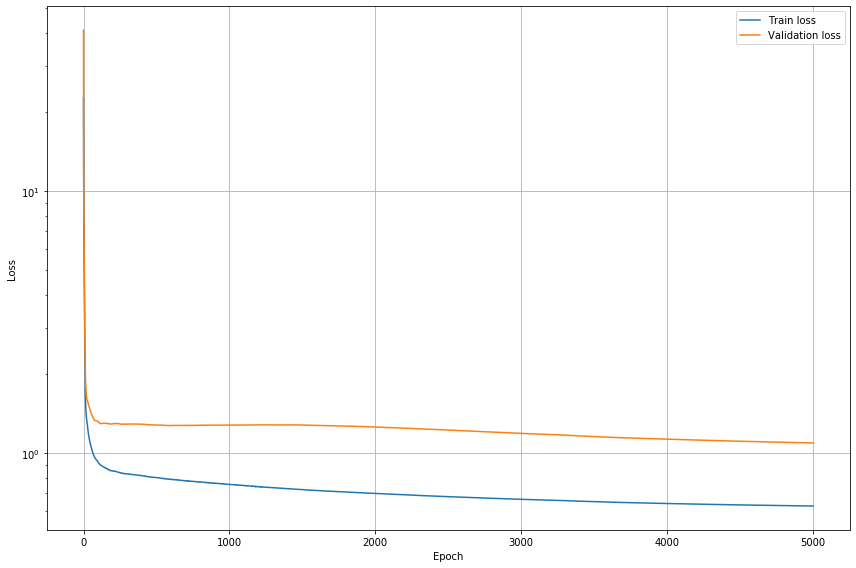

Epoch 200 - lr: 0.00091 - Train loss: 0.92652 - Valitation loss: 0.98332
Epoch 400 - lr: 0.00083 - Train loss: 0.82768 - Valitation loss: 0.94434
Epoch 600 - lr: 0.00076 - Train loss: 0.77887 - Valitation loss: 0.93207
Epoch 800 - lr: 0.00069 - Train loss: 0.74892 - Valitation loss: 0.92458
Epoch 1000 - lr: 0.00063 - Train loss: 0.72662 - Valitation loss: 0.92017
Epoch 1200 - lr: 0.00058 - Train loss: 0.70966 - Valitation loss: 0.91727
Epoch 1400 - lr: 0.00052 - Train loss: 0.69621 - Valitation loss: 0.91502
Epoch 1600 - lr: 0.00048 - Train loss: 0.68425 - Valitation loss: 0.91316
Epoch 1800 - lr: 0.00044 - Train loss: 0.67366 - Valitation loss: 0.91221
Epoch 2000 - lr: 0.00040 - Train loss: 0.66465 - Valitation loss: 0.91162
Epoch 2200 - lr: 0.00036 - Train loss: 0.65671 - Valitation loss: 0.91116
Epoch 2400 - lr: 0.00033 - Train loss: 0.64951 - Valitation loss: 0.91069
Epoch 2600 - lr: 0.00030 - Train loss: 0.64308 - Valitation loss: 0.91039
Epoch 2800 - lr: 0.00028 - Train loss: 0.6

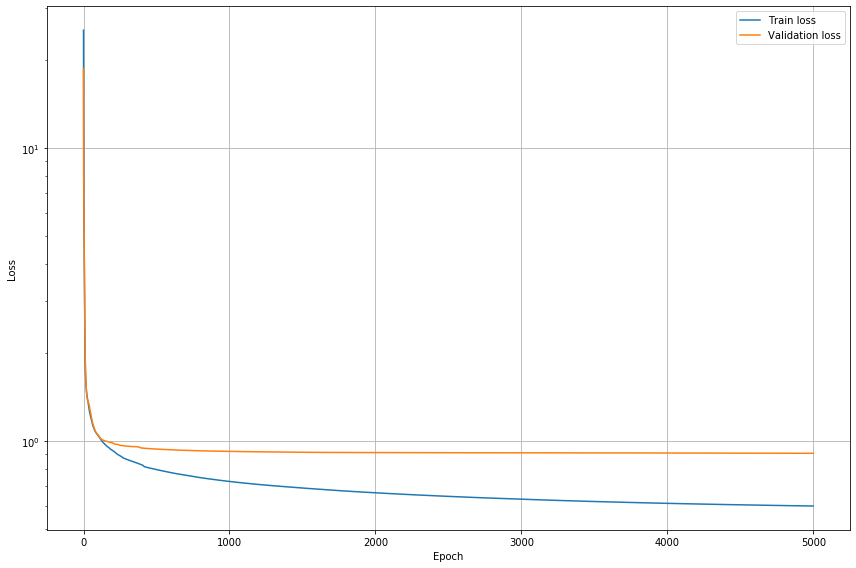

Epoch 200 - lr: 0.00091 - Train loss: 1.09567 - Valitation loss: 1.08045
Epoch 400 - lr: 0.00083 - Train loss: 0.96025 - Valitation loss: 0.93528
Epoch 600 - lr: 0.00076 - Train loss: 0.86327 - Valitation loss: 0.83320
Epoch 800 - lr: 0.00069 - Train loss: 0.81163 - Valitation loss: 0.79530
Epoch 1000 - lr: 0.00063 - Train loss: 0.78301 - Valitation loss: 0.77705
Epoch 1200 - lr: 0.00058 - Train loss: 0.76411 - Valitation loss: 0.76585
Epoch 1400 - lr: 0.00052 - Train loss: 0.74986 - Valitation loss: 0.75814
Epoch 1600 - lr: 0.00048 - Train loss: 0.73813 - Valitation loss: 0.75304
Epoch 1800 - lr: 0.00044 - Train loss: 0.72806 - Valitation loss: 0.75064
Epoch 2000 - lr: 0.00040 - Train loss: 0.71931 - Valitation loss: 0.74694
Epoch 2200 - lr: 0.00036 - Train loss: 0.71176 - Valitation loss: 0.74513
Epoch 2400 - lr: 0.00033 - Train loss: 0.70510 - Valitation loss: 0.74419
Epoch 2600 - lr: 0.00030 - Train loss: 0.69888 - Valitation loss: 0.74201
Epoch 2800 - lr: 0.00028 - Train loss: 0.6

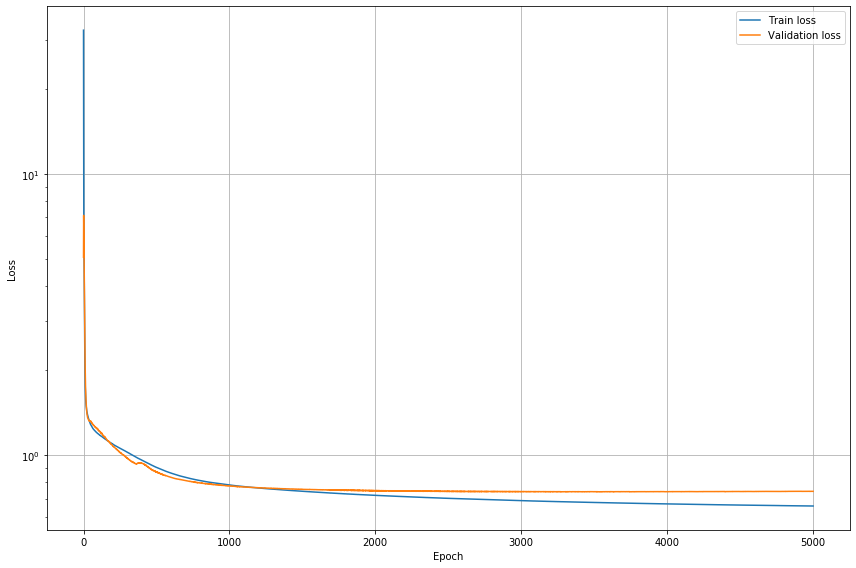

Epoch 200 - lr: 0.00091 - Train loss: 1.03394 - Valitation loss: 0.78127
Epoch 400 - lr: 0.00083 - Train loss: 0.95831 - Valitation loss: 0.64540
Epoch 600 - lr: 0.00076 - Train loss: 0.91249 - Valitation loss: 0.58050
Epoch 800 - lr: 0.00069 - Train loss: 0.87871 - Valitation loss: 0.54615
Epoch 1000 - lr: 0.00063 - Train loss: 0.85323 - Valitation loss: 0.51787
Epoch 1200 - lr: 0.00058 - Train loss: 0.83281 - Valitation loss: 0.50397
Epoch 1400 - lr: 0.00052 - Train loss: 0.81613 - Valitation loss: 0.49253
Epoch 1600 - lr: 0.00048 - Train loss: 0.80201 - Valitation loss: 0.48504
Epoch 1800 - lr: 0.00044 - Train loss: 0.79013 - Valitation loss: 0.48023
Epoch 2000 - lr: 0.00040 - Train loss: 0.77977 - Valitation loss: 0.47961
Epoch 2200 - lr: 0.00036 - Train loss: 0.77068 - Valitation loss: 0.47759
Epoch 2400 - lr: 0.00033 - Train loss: 0.76333 - Valitation loss: 0.47506
Epoch 2600 - lr: 0.00030 - Train loss: 0.75699 - Valitation loss: 0.47447
Epoch 2800 - lr: 0.00028 - Train loss: 0.7

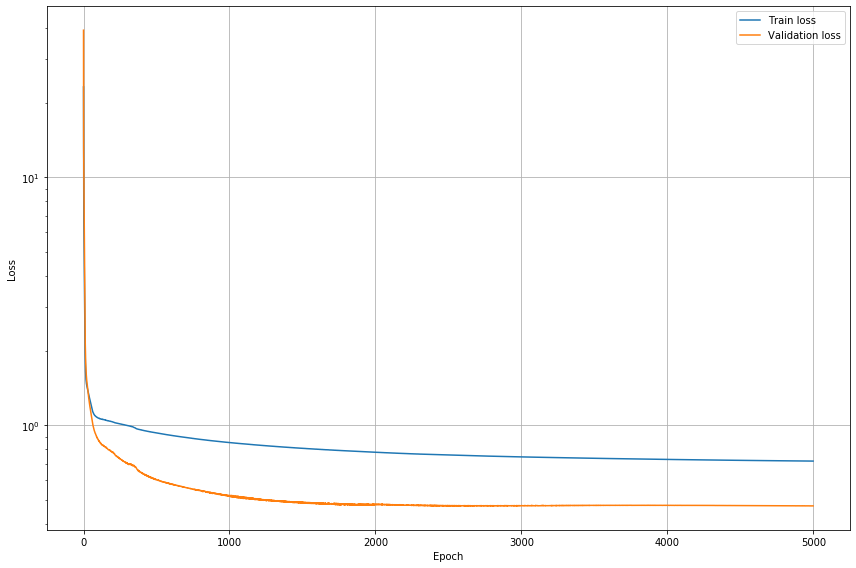

Epoch 200 - lr: 0.00091 - Train loss: 0.99563 - Valitation loss: 1.16771
Epoch 400 - lr: 0.00083 - Train loss: 0.93093 - Valitation loss: 1.05513
Epoch 600 - lr: 0.00076 - Train loss: 0.87989 - Valitation loss: 0.98377
Epoch 800 - lr: 0.00069 - Train loss: 0.84607 - Valitation loss: 0.92391
Epoch 1000 - lr: 0.00063 - Train loss: 0.81888 - Valitation loss: 0.87264
Epoch 1200 - lr: 0.00058 - Train loss: 0.79805 - Valitation loss: 0.85161
Epoch 1400 - lr: 0.00052 - Train loss: 0.78167 - Valitation loss: 0.82695
Epoch 1600 - lr: 0.00048 - Train loss: 0.76790 - Valitation loss: 0.80190
Epoch 1800 - lr: 0.00044 - Train loss: 0.75658 - Valitation loss: 0.78286
Epoch 2000 - lr: 0.00040 - Train loss: 0.74722 - Valitation loss: 0.77011
Epoch 2200 - lr: 0.00036 - Train loss: 0.73931 - Valitation loss: 0.76466
Epoch 2400 - lr: 0.00033 - Train loss: 0.73177 - Valitation loss: 0.75195
Epoch 2600 - lr: 0.00030 - Train loss: 0.72533 - Valitation loss: 0.74973
Epoch 2800 - lr: 0.00028 - Train loss: 0.7

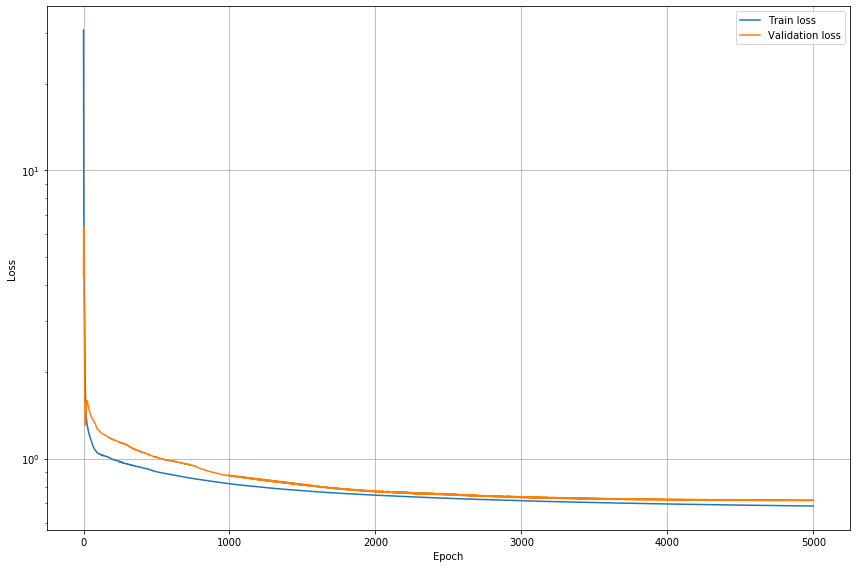

Epoch 200 - lr: 0.00091 - Train loss: 0.98540 - Valitation loss: 0.76748
Epoch 400 - lr: 0.00083 - Train loss: 0.86917 - Valitation loss: 0.70723
Epoch 600 - lr: 0.00076 - Train loss: 0.83182 - Valitation loss: 0.68519
Epoch 800 - lr: 0.00069 - Train loss: 0.80709 - Valitation loss: 0.67165
Epoch 1000 - lr: 0.00063 - Train loss: 0.78813 - Valitation loss: 0.66363
Epoch 1200 - lr: 0.00058 - Train loss: 0.77298 - Valitation loss: 0.65726
Epoch 1400 - lr: 0.00052 - Train loss: 0.76042 - Valitation loss: 0.65271
Epoch 1600 - lr: 0.00048 - Train loss: 0.74965 - Valitation loss: 0.64864
Epoch 1800 - lr: 0.00044 - Train loss: 0.74043 - Valitation loss: 0.64542
Epoch 2000 - lr: 0.00040 - Train loss: 0.73243 - Valitation loss: 0.64273
Epoch 2200 - lr: 0.00036 - Train loss: 0.72533 - Valitation loss: 0.64098
Epoch 2400 - lr: 0.00033 - Train loss: 0.71902 - Valitation loss: 0.63943
Epoch 2600 - lr: 0.00030 - Train loss: 0.71341 - Valitation loss: 0.63827
Epoch 2800 - lr: 0.00028 - Train loss: 0.7

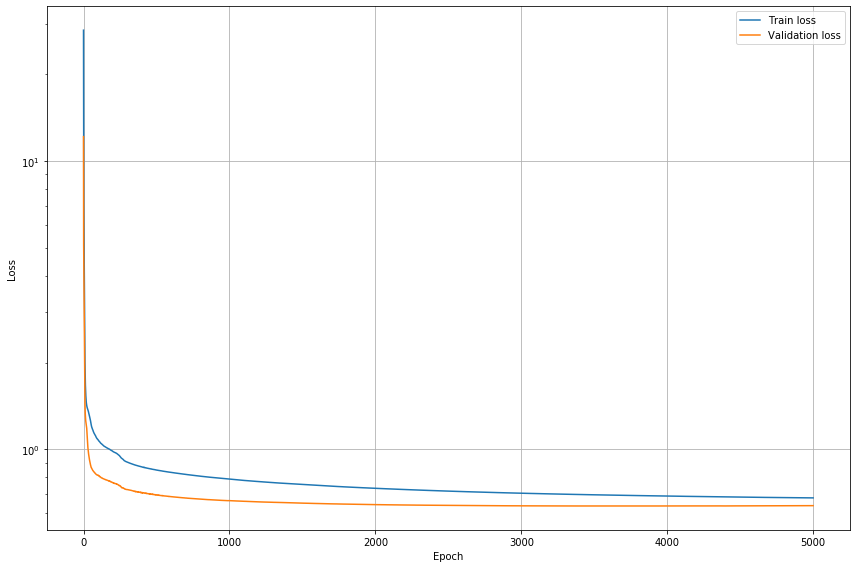


Parameters:
Nh1,Nh2: 200 200
Activation function: ReLU
Regularizer: l2 	Coefficient: 0.01

Epoch 200 - lr: 0.00091 - Train loss: 0.81034 - Valitation loss: 1.27635
Epoch 400 - lr: 0.00083 - Train loss: 0.75014 - Valitation loss: 1.24263
Epoch 600 - lr: 0.00076 - Train loss: 0.73430 - Valitation loss: 1.24996
Epoch 800 - lr: 0.00069 - Train loss: 0.72664 - Valitation loss: 1.25821
Epoch 1000 - lr: 0.00063 - Train loss: 0.72081 - Valitation loss: 1.26694
Epoch 1200 - lr: 0.00058 - Train loss: 0.71594 - Valitation loss: 1.27607
Epoch 1400 - lr: 0.00052 - Train loss: 0.71227 - Valitation loss: 1.28426
Epoch 1600 - lr: 0.00048 - Train loss: 0.70796 - Valitation loss: 1.28822
Epoch 1800 - lr: 0.00044 - Train loss: 0.70203 - Valitation loss: 1.28049
Epoch 2000 - lr: 0.00040 - Train loss: 0.69636 - Valitation loss: 1.27275
Epoch 2200 - lr: 0.00036 - Train loss: 0.69068 - Valitation loss: 1.26260
Epoch 2400 - lr: 0.00033 - Train loss: 0.68523 - Valitation loss: 1.25050
Epoch 2600 - lr: 0.00030

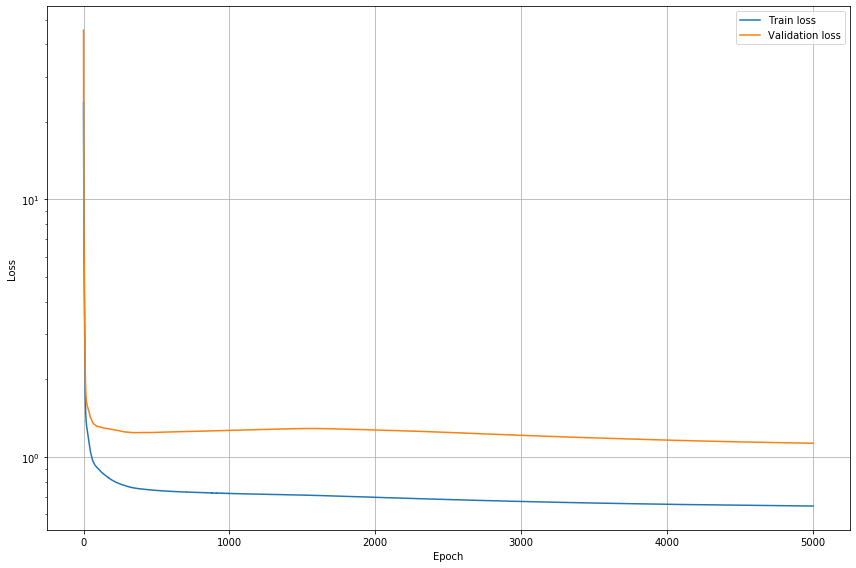

Epoch 200 - lr: 0.00091 - Train loss: 0.94294 - Valitation loss: 0.99195
Epoch 400 - lr: 0.00083 - Train loss: 0.82569 - Valitation loss: 0.94394
Epoch 600 - lr: 0.00076 - Train loss: 0.78432 - Valitation loss: 0.93247
Epoch 800 - lr: 0.00069 - Train loss: 0.75354 - Valitation loss: 0.92451
Epoch 1000 - lr: 0.00063 - Train loss: 0.73045 - Valitation loss: 0.91997
Epoch 1200 - lr: 0.00058 - Train loss: 0.71230 - Valitation loss: 0.91703
Epoch 1400 - lr: 0.00052 - Train loss: 0.69797 - Valitation loss: 0.91491
Epoch 1600 - lr: 0.00048 - Train loss: 0.68582 - Valitation loss: 0.91355
Epoch 1800 - lr: 0.00044 - Train loss: 0.67498 - Valitation loss: 0.91254
Epoch 2000 - lr: 0.00040 - Train loss: 0.66553 - Valitation loss: 0.91185
Epoch 2200 - lr: 0.00036 - Train loss: 0.65720 - Valitation loss: 0.91134
Epoch 2400 - lr: 0.00033 - Train loss: 0.64976 - Valitation loss: 0.91095
Epoch 2600 - lr: 0.00030 - Train loss: 0.64298 - Valitation loss: 0.91058
Epoch 2800 - lr: 0.00028 - Train loss: 0.6

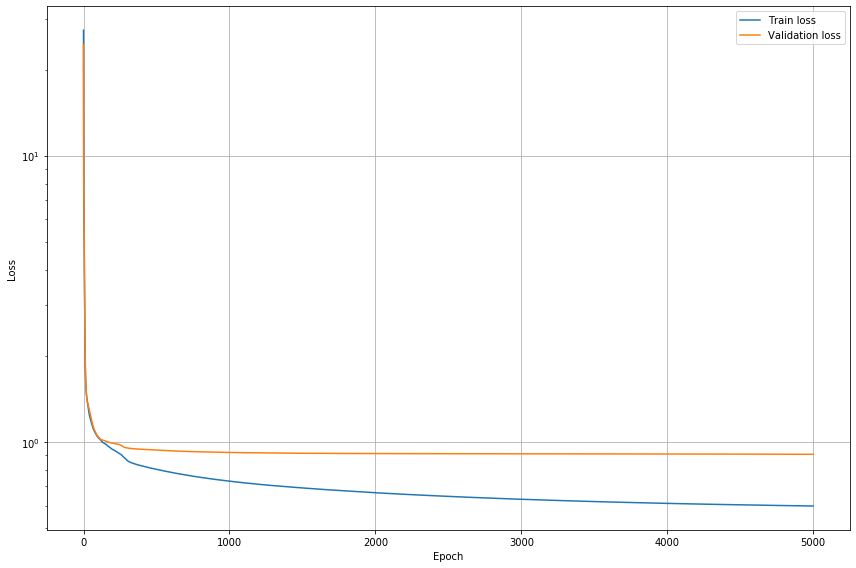

Epoch 200 - lr: 0.00091 - Train loss: 1.06252 - Valitation loss: 1.03358
Epoch 400 - lr: 0.00083 - Train loss: 0.92587 - Valitation loss: 0.88834
Epoch 600 - lr: 0.00076 - Train loss: 0.84638 - Valitation loss: 0.81724
Epoch 800 - lr: 0.00069 - Train loss: 0.80465 - Valitation loss: 0.78575
Epoch 1000 - lr: 0.00063 - Train loss: 0.78034 - Valitation loss: 0.77032
Epoch 1200 - lr: 0.00058 - Train loss: 0.76294 - Valitation loss: 0.76143
Epoch 1400 - lr: 0.00052 - Train loss: 0.74895 - Valitation loss: 0.75468
Epoch 1600 - lr: 0.00048 - Train loss: 0.73718 - Valitation loss: 0.75000
Epoch 1800 - lr: 0.00044 - Train loss: 0.72690 - Valitation loss: 0.74702
Epoch 2000 - lr: 0.00040 - Train loss: 0.71794 - Valitation loss: 0.74399
Epoch 2200 - lr: 0.00036 - Train loss: 0.70958 - Valitation loss: 0.74035
Epoch 2400 - lr: 0.00033 - Train loss: 0.70235 - Valitation loss: 0.73876
Epoch 2600 - lr: 0.00030 - Train loss: 0.69590 - Valitation loss: 0.73738
Epoch 2800 - lr: 0.00028 - Train loss: 0.6

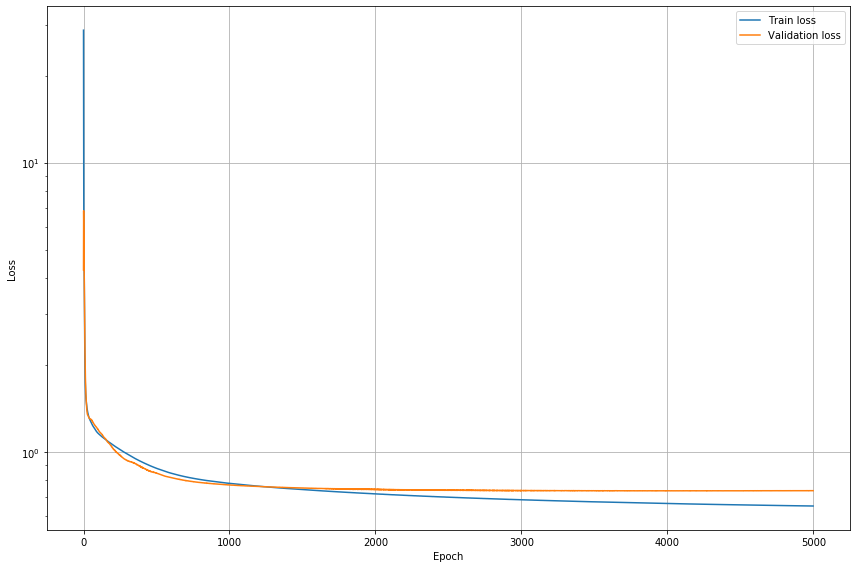

Epoch 200 - lr: 0.00091 - Train loss: 1.05406 - Valitation loss: 0.85699
Epoch 400 - lr: 0.00083 - Train loss: 0.95855 - Valitation loss: 0.66069
Epoch 600 - lr: 0.00076 - Train loss: 0.89717 - Valitation loss: 0.56526
Epoch 800 - lr: 0.00069 - Train loss: 0.85543 - Valitation loss: 0.50761
Epoch 1000 - lr: 0.00063 - Train loss: 0.82970 - Valitation loss: 0.47784
Epoch 1200 - lr: 0.00058 - Train loss: 0.81205 - Valitation loss: 0.45976
Epoch 1400 - lr: 0.00052 - Train loss: 0.79740 - Valitation loss: 0.45822
Epoch 1600 - lr: 0.00048 - Train loss: 0.78605 - Valitation loss: 0.45263
Epoch 1800 - lr: 0.00044 - Train loss: 0.77640 - Valitation loss: 0.45157
Epoch 2000 - lr: 0.00040 - Train loss: 0.76866 - Valitation loss: 0.45026
Epoch 2200 - lr: 0.00036 - Train loss: 0.76180 - Valitation loss: 0.45149
Epoch 2400 - lr: 0.00033 - Train loss: 0.75578 - Valitation loss: 0.45372
Epoch 2600 - lr: 0.00030 - Train loss: 0.75023 - Valitation loss: 0.45567
Epoch 2800 - lr: 0.00028 - Train loss: 0.7

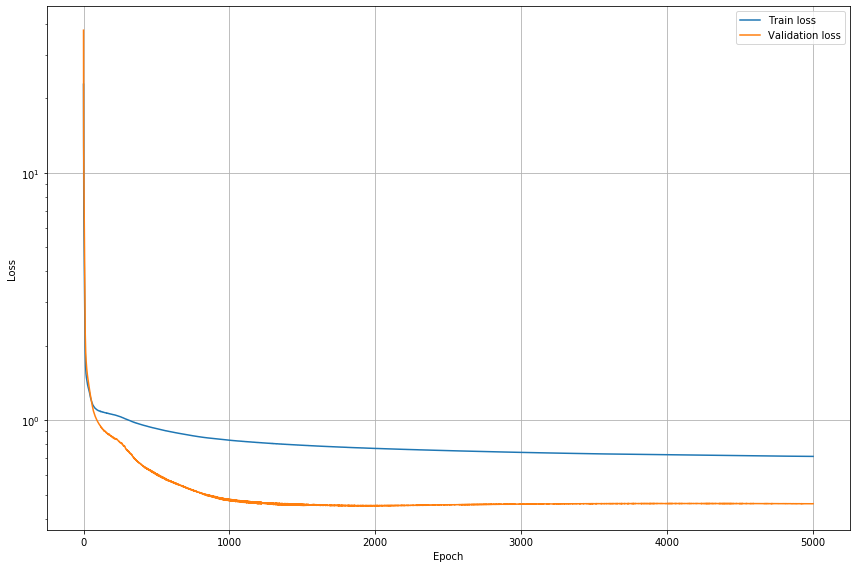

Epoch 200 - lr: 0.00091 - Train loss: 1.00158 - Valitation loss: 1.20772
Epoch 400 - lr: 0.00083 - Train loss: 0.91455 - Valitation loss: 1.02769
Epoch 600 - lr: 0.00076 - Train loss: 0.85438 - Valitation loss: 0.91688
Epoch 800 - lr: 0.00069 - Train loss: 0.82168 - Valitation loss: 0.84041
Epoch 1000 - lr: 0.00063 - Train loss: 0.79924 - Valitation loss: 0.81142
Epoch 1200 - lr: 0.00058 - Train loss: 0.78322 - Valitation loss: 0.78992
Epoch 1400 - lr: 0.00052 - Train loss: 0.77063 - Valitation loss: 0.77754
Epoch 1600 - lr: 0.00048 - Train loss: 0.75978 - Valitation loss: 0.76933
Epoch 1800 - lr: 0.00044 - Train loss: 0.75070 - Valitation loss: 0.76035
Epoch 2000 - lr: 0.00040 - Train loss: 0.74265 - Valitation loss: 0.75239
Epoch 2200 - lr: 0.00036 - Train loss: 0.73582 - Valitation loss: 0.75201
Epoch 2400 - lr: 0.00033 - Train loss: 0.72939 - Valitation loss: 0.74647
Epoch 2600 - lr: 0.00030 - Train loss: 0.72363 - Valitation loss: 0.74074
Epoch 2800 - lr: 0.00028 - Train loss: 0.7

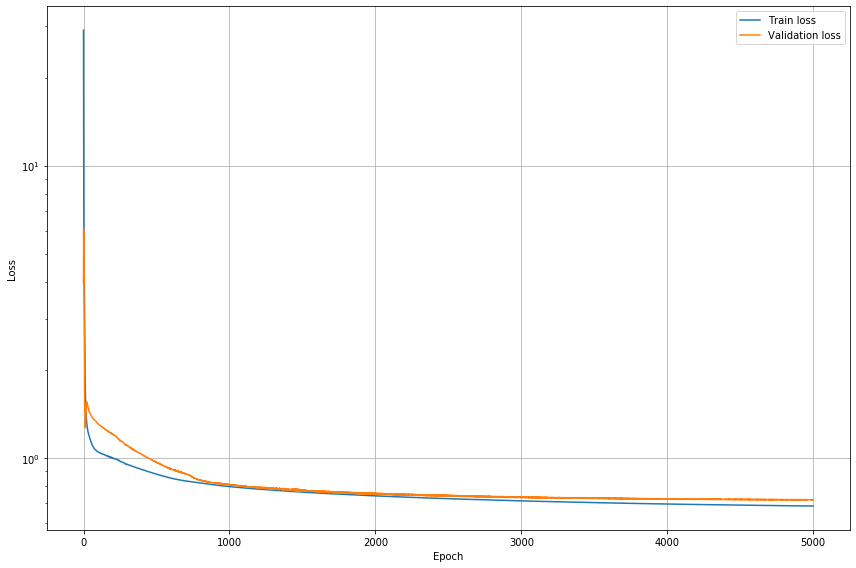

Epoch 200 - lr: 0.00091 - Train loss: 0.99924 - Valitation loss: 0.76578
Epoch 400 - lr: 0.00083 - Train loss: 0.88988 - Valitation loss: 0.71157
Epoch 600 - lr: 0.00076 - Train loss: 0.84865 - Valitation loss: 0.68663
Epoch 800 - lr: 0.00069 - Train loss: 0.82140 - Valitation loss: 0.67198
Epoch 1000 - lr: 0.00063 - Train loss: 0.80030 - Valitation loss: 0.66024
Epoch 1200 - lr: 0.00058 - Train loss: 0.78320 - Valitation loss: 0.65190
Epoch 1400 - lr: 0.00052 - Train loss: 0.76894 - Valitation loss: 0.64602
Epoch 1600 - lr: 0.00048 - Train loss: 0.75708 - Valitation loss: 0.64156
Epoch 1800 - lr: 0.00044 - Train loss: 0.74700 - Valitation loss: 0.63774
Epoch 2000 - lr: 0.00040 - Train loss: 0.73823 - Valitation loss: 0.63534
Epoch 2200 - lr: 0.00036 - Train loss: 0.73056 - Valitation loss: 0.63302
Epoch 2400 - lr: 0.00033 - Train loss: 0.72383 - Valitation loss: 0.63103
Epoch 2600 - lr: 0.00030 - Train loss: 0.71814 - Valitation loss: 0.62943
Epoch 2800 - lr: 0.00028 - Train loss: 0.7

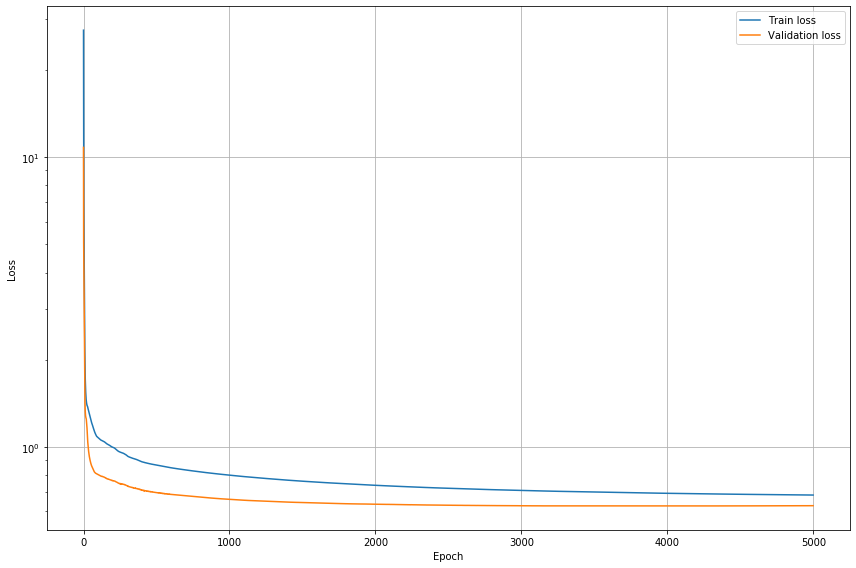

In [18]:
# Doing cross validation

#%% TRAINING PARAMETERS
min_epochs = 5000
num_epochs = 10000
lr = 0.001
en_decay = True
lr_final = 0.00001
lr_decay = (lr_final / lr)**(1 / num_epochs)
regul = "l2"
lambda_regul = 0.01

NN_act_f = ReLU
NN_d_act_f = d_ReLU

# Conventionally not training on a grid but using same number of neurons
for Nh1,Nh2 in zip(Nh1_list,Nh2_list):

    valid_losses = []

    print("\nParameters:")
    print("Nh1,Nh2:", Nh1, Nh2)
    print("Activation function:", NN_act_f.__name__)
    print("Regularizer:", regul, "\tCoefficient:", lambda_regul, end="\n\n")

    for ind_set in range(len(x_train_sets)):
        # Defining the NN
        #net = Network(Ni, Nh1, Nh2, No, NN_act_f, NN_d_act_f)
        net = Network_reg(Ni, Nh1, Nh2, No, NN_act_f, NN_d_act_f, regul, lambda_regul)

        # Preparing loss lists
        train_loss_log = []
        valid_loss_log = []

        # Refreshing learning rate
        lr = 0.001
        
        # Training NN on k-fold
        for num_ep in range(num_epochs):
            # Learning rate decay
            if en_decay:
                lr *= lr_decay
            # Train single epoch (sample by sample, no batch for now)
            train_loss_vec = [net.update(x, y, lr) for x, y in zip(x_train_sets[ind_set], y_train_sets[ind_set])]
            avg_train_loss = np.mean(train_loss_vec)
            # Test network
            y_valid_est = np.array([net.forward(x) for x in x_valid_sets[ind_set]])
            avg_valid_loss = np.mean((y_valid_est - y_valid_sets[ind_set])**2/2)
            
            # Log (using validation error list for early stopping)
            train_loss_log.append(avg_train_loss)
            valid_loss_log.append(avg_valid_loss)

            # Trying a condition for early stopping
            if ( (len(valid_loss_log)>=min_epochs) and (valid_loss_log[-1]>valid_loss_log[-2]) ):
                print("\nEARLY STOPPING:")
                print('Epoch %d - lr: %.5f - Train loss: %.5f - Valitation loss: %.5f' % (num_ep + 1, lr, avg_train_loss, avg_valid_loss), end="\n\n")
                break

            if (num_ep%200 == 199):
                print('Epoch %d - lr: %.5f - Train loss: %.5f - Valitation loss: %.5f' % (num_ep + 1, lr, avg_train_loss, avg_valid_loss))


        errors_dictio[str(NN_act_f.__name__)+str(Nh1)+str(Nh2)+regul+str(2*lambda_regul)+"valid"+str(ind_set)] = valid_loss_log[-2]


        valid_losses.append(valid_loss_log[-1])
        
        # Plot losses
        plt.close('all')
        plt.figure(figsize=(12,8))
        plt.semilogy(train_loss_log, label='Train loss')
        plt.semilogy(valid_loss_log, label='Validation loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid()
        plt.legend()
        plt.tight_layout()
        plt.show()

    temp_val_loss = np.mean(valid_losses)

    if (best_error == None or temp_val_loss < best_error):
        best_error = temp_val_loss
        NN_act_f_best = NN_act_f
        Nh1_best = Nh1
        Nh2_best = Nh2

In [19]:
print(best_error)
print(NN_act_f_best)
print(Nh1_best)
print(Nh2_best)

0.6459823792653834
<function ReLU at 0x7f5e5e211268>
50
50


In [20]:
errors_dictio

{'expit5050l20.02valid0': 2.4444197493056516,
 'expit5050l20.02valid1': 1.620443676598492,
 'expit5050l20.02valid2': 1.0785823462150093,
 'expit5050l20.02valid3': 4.821342904448395,
 'expit5050l20.02valid4': 1.5179142450823804,
 'expit5050l20.02valid5': 2.011067222350301,
 'expit100100l20.02valid0': 2.328962792146696,
 'expit100100l20.02valid1': 1.8813379328318944,
 'expit100100l20.02valid2': 1.8587367564828816,
 'expit100100l20.02valid3': 4.973225424278272,
 'expit100100l20.02valid4': 2.582980478650188,
 'expit100100l20.02valid5': 2.017698511137269,
 'expit200200l20.02valid0': 27.103824752995724,
 'expit200200l20.02valid1': nan,
 'expit200200l20.02valid2': 11.353404424172613,
 'expit200200l20.02valid3': 24.74219685371748,
 'expit200200l20.02valid4': 10.912804711398778,
 'expit200200l20.02valid5': 10.244082583974361,
 'ReLU5050l20.02valid0': 1.1367005192137354,
 'ReLU5050l20.02valid1': 0.9047893050526463,
 'ReLU5050l20.02valid2': 0.719509803462796,
 'ReLU5050l20.02valid3': 0.4392245462

## ELU

- Min epocs: 5000 (quite fast to train).
- Starting learning rate: 0.001

(Parameters are the same as ReLU)


Parameters:
Nh1,Nh2: 50 50
Activation function: ELU
Regularizer: l2 	Coefficient: 0.01

Epoch 200 - lr: 0.00091 - Train loss: 0.94773 - Valitation loss: 1.16302
Epoch 400 - lr: 0.00083 - Train loss: 0.77634 - Valitation loss: 1.09028
Epoch 600 - lr: 0.00076 - Train loss: 0.74309 - Valitation loss: 1.10961
Epoch 800 - lr: 0.00069 - Train loss: 0.72533 - Valitation loss: 1.12015
Epoch 1000 - lr: 0.00063 - Train loss: 0.71262 - Valitation loss: 1.12392
Epoch 1200 - lr: 0.00058 - Train loss: 0.70220 - Valitation loss: 1.12375
Epoch 1400 - lr: 0.00052 - Train loss: 0.69368 - Valitation loss: 1.12259
Epoch 1600 - lr: 0.00048 - Train loss: 0.68656 - Valitation loss: 1.12084
Epoch 1800 - lr: 0.00044 - Train loss: 0.68032 - Valitation loss: 1.11824
Epoch 2000 - lr: 0.00040 - Train loss: 0.67477 - Valitation loss: 1.11493
Epoch 2200 - lr: 0.00036 - Train loss: 0.66931 - Valitation loss: 1.10991
Epoch 2400 - lr: 0.00033 - Train loss: 0.66397 - Valitation loss: 1.10459
Epoch 2600 - lr: 0.00030 - 

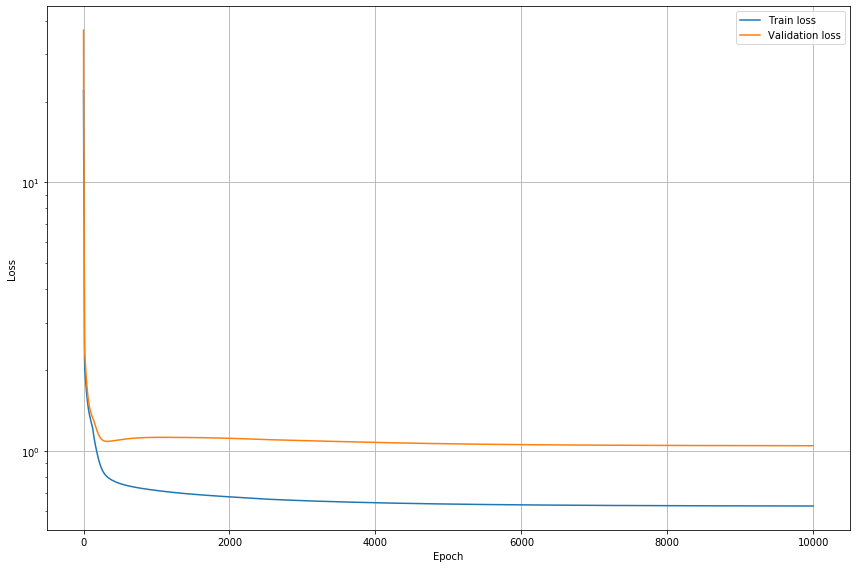

Epoch 200 - lr: 0.00091 - Train loss: 1.15566 - Valitation loss: 1.15553
Epoch 400 - lr: 0.00083 - Train loss: 0.98693 - Valitation loss: 1.01584
Epoch 600 - lr: 0.00076 - Train loss: 0.85872 - Valitation loss: 0.94341
Epoch 800 - lr: 0.00069 - Train loss: 0.78122 - Valitation loss: 0.92879
Epoch 1000 - lr: 0.00063 - Train loss: 0.74563 - Valitation loss: 0.93375
Epoch 1200 - lr: 0.00058 - Train loss: 0.72531 - Valitation loss: 0.94003
Epoch 1400 - lr: 0.00052 - Train loss: 0.71024 - Valitation loss: 0.94491
Epoch 1600 - lr: 0.00048 - Train loss: 0.69775 - Valitation loss: 0.94833
Epoch 1800 - lr: 0.00044 - Train loss: 0.68698 - Valitation loss: 0.95046
Epoch 2000 - lr: 0.00040 - Train loss: 0.67799 - Valitation loss: 0.95221
Epoch 2200 - lr: 0.00036 - Train loss: 0.67041 - Valitation loss: 0.95370
Epoch 2400 - lr: 0.00033 - Train loss: 0.66373 - Valitation loss: 0.95480
Epoch 2600 - lr: 0.00030 - Train loss: 0.65782 - Valitation loss: 0.95572
Epoch 2800 - lr: 0.00028 - Train loss: 0.6

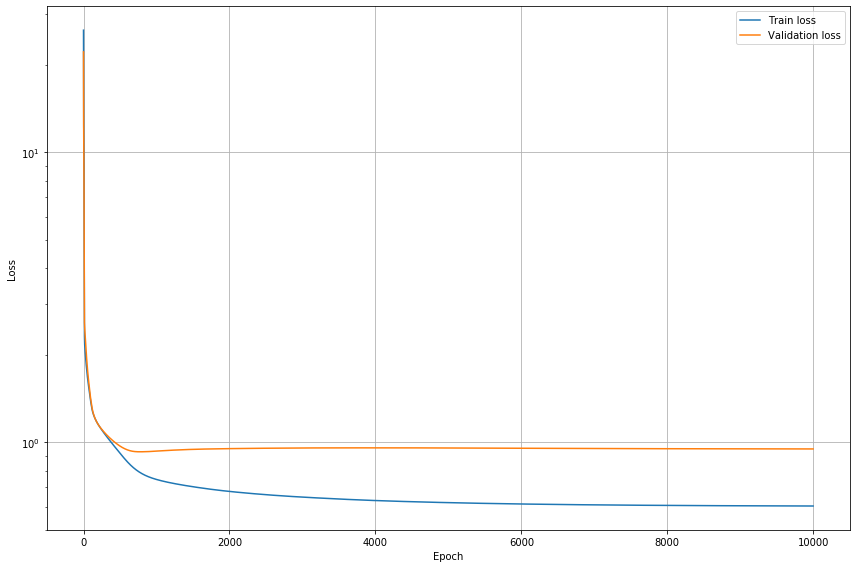

Epoch 200 - lr: 0.00091 - Train loss: 1.14918 - Valitation loss: 1.18916
Epoch 400 - lr: 0.00083 - Train loss: 0.88264 - Valitation loss: 0.91182
Epoch 600 - lr: 0.00076 - Train loss: 0.84651 - Valitation loss: 0.85098
Epoch 800 - lr: 0.00069 - Train loss: 0.82096 - Valitation loss: 0.82446
Epoch 1000 - lr: 0.00063 - Train loss: 0.80030 - Valitation loss: 0.80636
Epoch 1200 - lr: 0.00058 - Train loss: 0.78305 - Valitation loss: 0.79172
Epoch 1400 - lr: 0.00052 - Train loss: 0.76914 - Valitation loss: 0.78069
Epoch 1600 - lr: 0.00048 - Train loss: 0.75770 - Valitation loss: 0.77228
Epoch 1800 - lr: 0.00044 - Train loss: 0.74787 - Valitation loss: 0.76535
Epoch 2000 - lr: 0.00040 - Train loss: 0.73912 - Valitation loss: 0.75925
Epoch 2200 - lr: 0.00036 - Train loss: 0.73075 - Valitation loss: 0.75309
Epoch 2400 - lr: 0.00033 - Train loss: 0.72348 - Valitation loss: 0.74763
Epoch 2600 - lr: 0.00030 - Train loss: 0.71737 - Valitation loss: 0.74367
Epoch 2800 - lr: 0.00028 - Train loss: 0.7

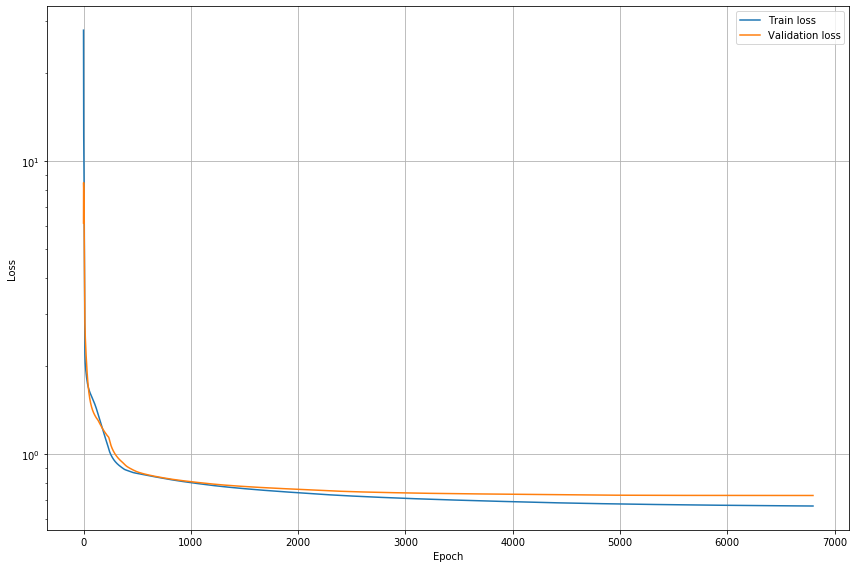

Epoch 200 - lr: 0.00091 - Train loss: 1.16178 - Valitation loss: 1.14785
Epoch 400 - lr: 0.00083 - Train loss: 1.01609 - Valitation loss: 0.74593
Epoch 600 - lr: 0.00076 - Train loss: 0.93529 - Valitation loss: 0.54448
Epoch 800 - lr: 0.00069 - Train loss: 0.88697 - Valitation loss: 0.43905
Epoch 1000 - lr: 0.00063 - Train loss: 0.84148 - Valitation loss: 0.34969
Epoch 1200 - lr: 0.00058 - Train loss: 0.82325 - Valitation loss: 0.35754
Epoch 1400 - lr: 0.00052 - Train loss: 0.80443 - Valitation loss: 0.36395
Epoch 1600 - lr: 0.00048 - Train loss: 0.79145 - Valitation loss: 0.36903
Epoch 1800 - lr: 0.00044 - Train loss: 0.77991 - Valitation loss: 0.37595
Epoch 2000 - lr: 0.00040 - Train loss: 0.76948 - Valitation loss: 0.38170
Epoch 2200 - lr: 0.00036 - Train loss: 0.76208 - Valitation loss: 0.38556
Epoch 2400 - lr: 0.00033 - Train loss: 0.75600 - Valitation loss: 0.38893
Epoch 2600 - lr: 0.00030 - Train loss: 0.75078 - Valitation loss: 0.39189
Epoch 2800 - lr: 0.00028 - Train loss: 0.7

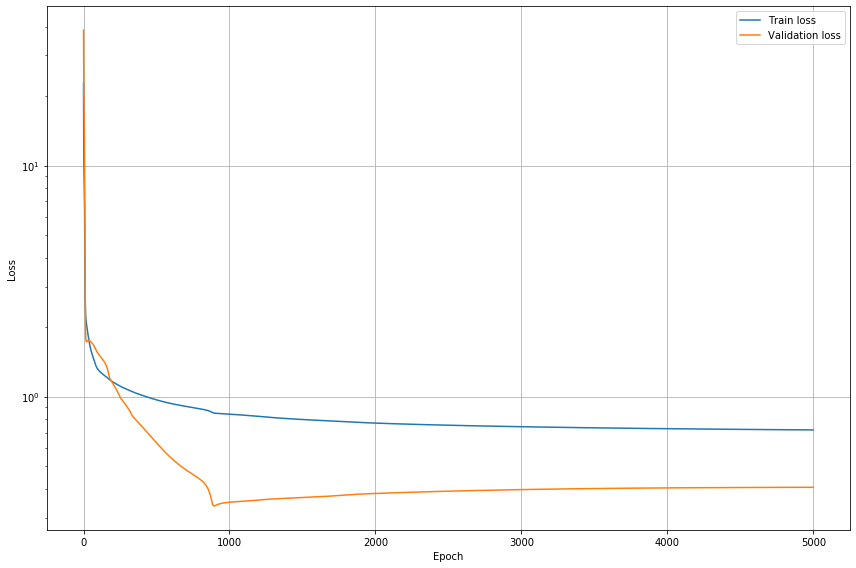

Epoch 200 - lr: 0.00091 - Train loss: 1.06892 - Valitation loss: 1.29551
Epoch 400 - lr: 0.00083 - Train loss: 0.90075 - Valitation loss: 1.10320
Epoch 600 - lr: 0.00076 - Train loss: 0.86168 - Valitation loss: 1.00519
Epoch 800 - lr: 0.00069 - Train loss: 0.83875 - Valitation loss: 0.93335
Epoch 1000 - lr: 0.00063 - Train loss: 0.82348 - Valitation loss: 0.90566
Epoch 1200 - lr: 0.00058 - Train loss: 0.80930 - Valitation loss: 0.87978
Epoch 1400 - lr: 0.00052 - Train loss: 0.79690 - Valitation loss: 0.85760
Epoch 1600 - lr: 0.00048 - Train loss: 0.78587 - Valitation loss: 0.83801
Epoch 1800 - lr: 0.00044 - Train loss: 0.77618 - Valitation loss: 0.82133
Epoch 2000 - lr: 0.00040 - Train loss: 0.76764 - Valitation loss: 0.80690
Epoch 2200 - lr: 0.00036 - Train loss: 0.76014 - Valitation loss: 0.79476
Epoch 2400 - lr: 0.00033 - Train loss: 0.75363 - Valitation loss: 0.78479
Epoch 2600 - lr: 0.00030 - Train loss: 0.74799 - Valitation loss: 0.77695
Epoch 2800 - lr: 0.00028 - Train loss: 0.7

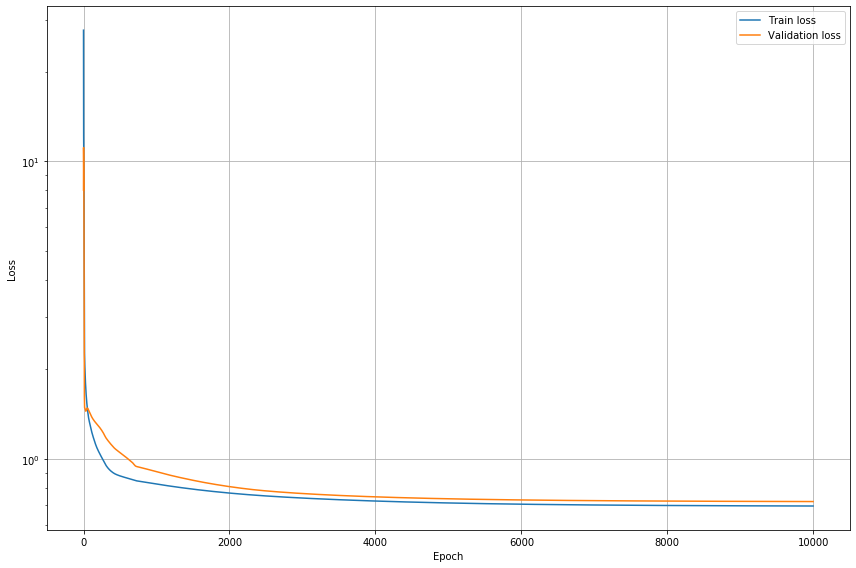

Epoch 200 - lr: 0.00091 - Train loss: 1.14793 - Valitation loss: 0.98150
Epoch 400 - lr: 0.00083 - Train loss: 0.94665 - Valitation loss: 0.84163
Epoch 600 - lr: 0.00076 - Train loss: 0.84124 - Valitation loss: 0.77083
Epoch 800 - lr: 0.00069 - Train loss: 0.81822 - Valitation loss: 0.75064
Epoch 1000 - lr: 0.00063 - Train loss: 0.79882 - Valitation loss: 0.73556
Epoch 1200 - lr: 0.00058 - Train loss: 0.78267 - Valitation loss: 0.72297
Epoch 1400 - lr: 0.00052 - Train loss: 0.76869 - Valitation loss: 0.71201
Epoch 1600 - lr: 0.00048 - Train loss: 0.75708 - Valitation loss: 0.70299
Epoch 1800 - lr: 0.00044 - Train loss: 0.74740 - Valitation loss: 0.69563
Epoch 2000 - lr: 0.00040 - Train loss: 0.73905 - Valitation loss: 0.68941
Epoch 2200 - lr: 0.00036 - Train loss: 0.73169 - Valitation loss: 0.68415
Epoch 2400 - lr: 0.00033 - Train loss: 0.72493 - Valitation loss: 0.67934
Epoch 2600 - lr: 0.00030 - Train loss: 0.71928 - Valitation loss: 0.67547
Epoch 2800 - lr: 0.00028 - Train loss: 0.7

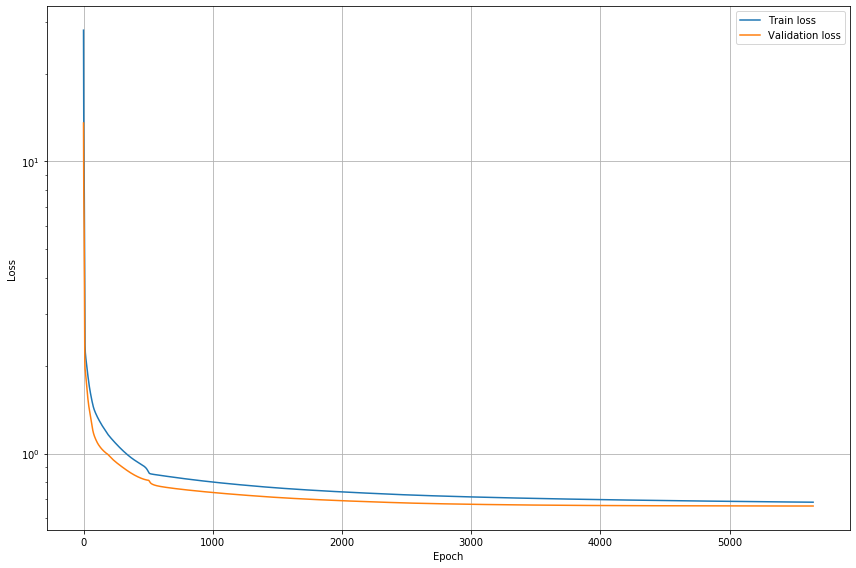


Parameters:
Nh1,Nh2: 100 100
Activation function: ELU
Regularizer: l2 	Coefficient: 0.01

Epoch 200 - lr: 0.00091 - Train loss: 1.11186 - Valitation loss: 1.26020
Epoch 400 - lr: 0.00083 - Train loss: 0.89152 - Valitation loss: 1.14392
Epoch 600 - lr: 0.00076 - Train loss: 0.79861 - Valitation loss: 1.14970
Epoch 800 - lr: 0.00069 - Train loss: 0.76111 - Valitation loss: 1.16529
Epoch 1000 - lr: 0.00063 - Train loss: 0.74685 - Valitation loss: 1.15984
Epoch 1200 - lr: 0.00058 - Train loss: 0.73455 - Valitation loss: 1.15246
Epoch 1400 - lr: 0.00052 - Train loss: 0.72402 - Valitation loss: 1.14558
Epoch 1600 - lr: 0.00048 - Train loss: 0.71557 - Valitation loss: 1.14050
Epoch 1800 - lr: 0.00044 - Train loss: 0.70844 - Valitation loss: 1.13624
Epoch 2000 - lr: 0.00040 - Train loss: 0.70253 - Valitation loss: 1.13285
Epoch 2200 - lr: 0.00036 - Train loss: 0.69743 - Valitation loss: 1.12969
Epoch 2400 - lr: 0.00033 - Train loss: 0.69291 - Valitation loss: 1.12643
Epoch 2600 - lr: 0.00030 

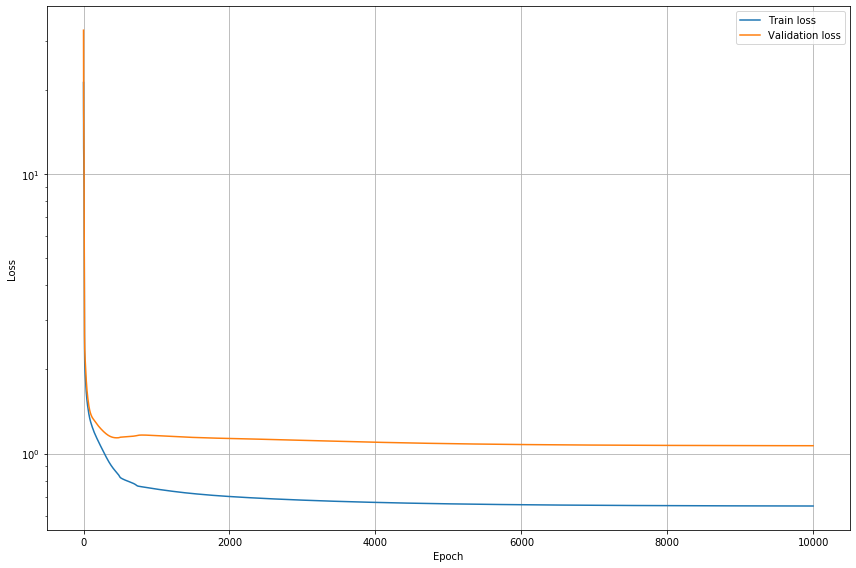

Epoch 200 - lr: 0.00091 - Train loss: 1.21467 - Valitation loss: 1.27038
Epoch 400 - lr: 0.00083 - Train loss: 0.90361 - Valitation loss: 0.95887
Epoch 600 - lr: 0.00076 - Train loss: 0.80747 - Valitation loss: 0.93197
Epoch 800 - lr: 0.00069 - Train loss: 0.77318 - Valitation loss: 0.93428
Epoch 1000 - lr: 0.00063 - Train loss: 0.74952 - Valitation loss: 0.93608
Epoch 1200 - lr: 0.00058 - Train loss: 0.73124 - Valitation loss: 0.93754
Epoch 1400 - lr: 0.00052 - Train loss: 0.71627 - Valitation loss: 0.93897
Epoch 1600 - lr: 0.00048 - Train loss: 0.70406 - Valitation loss: 0.94025
Epoch 1800 - lr: 0.00044 - Train loss: 0.69400 - Valitation loss: 0.94197
Epoch 2000 - lr: 0.00040 - Train loss: 0.68581 - Valitation loss: 0.94335
Epoch 2200 - lr: 0.00036 - Train loss: 0.67873 - Valitation loss: 0.94445
Epoch 2400 - lr: 0.00033 - Train loss: 0.67242 - Valitation loss: 0.94531
Epoch 2600 - lr: 0.00030 - Train loss: 0.66677 - Valitation loss: 0.94598
Epoch 2800 - lr: 0.00028 - Train loss: 0.6

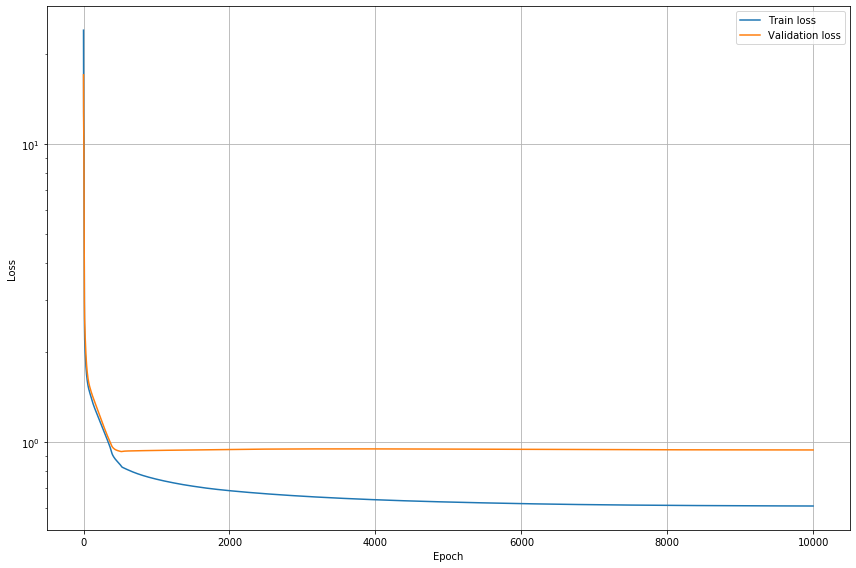

Epoch 200 - lr: 0.00091 - Train loss: 1.27472 - Valitation loss: 1.24673
Epoch 400 - lr: 0.00083 - Train loss: 0.88505 - Valitation loss: 0.92319
Epoch 600 - lr: 0.00076 - Train loss: 0.83944 - Valitation loss: 0.84535
Epoch 800 - lr: 0.00069 - Train loss: 0.81249 - Valitation loss: 0.81342
Epoch 1000 - lr: 0.00063 - Train loss: 0.79170 - Valitation loss: 0.79087
Epoch 1200 - lr: 0.00058 - Train loss: 0.77520 - Valitation loss: 0.77403
Epoch 1400 - lr: 0.00052 - Train loss: 0.76200 - Valitation loss: 0.76164
Epoch 1600 - lr: 0.00048 - Train loss: 0.75086 - Valitation loss: 0.75173
Epoch 1800 - lr: 0.00044 - Train loss: 0.74115 - Valitation loss: 0.74389
Epoch 2000 - lr: 0.00040 - Train loss: 0.73279 - Valitation loss: 0.73758
Epoch 2200 - lr: 0.00036 - Train loss: 0.72565 - Valitation loss: 0.73300
Epoch 2400 - lr: 0.00033 - Train loss: 0.71933 - Valitation loss: 0.72931
Epoch 2600 - lr: 0.00030 - Train loss: 0.71347 - Valitation loss: 0.72610
Epoch 2800 - lr: 0.00028 - Train loss: 0.7

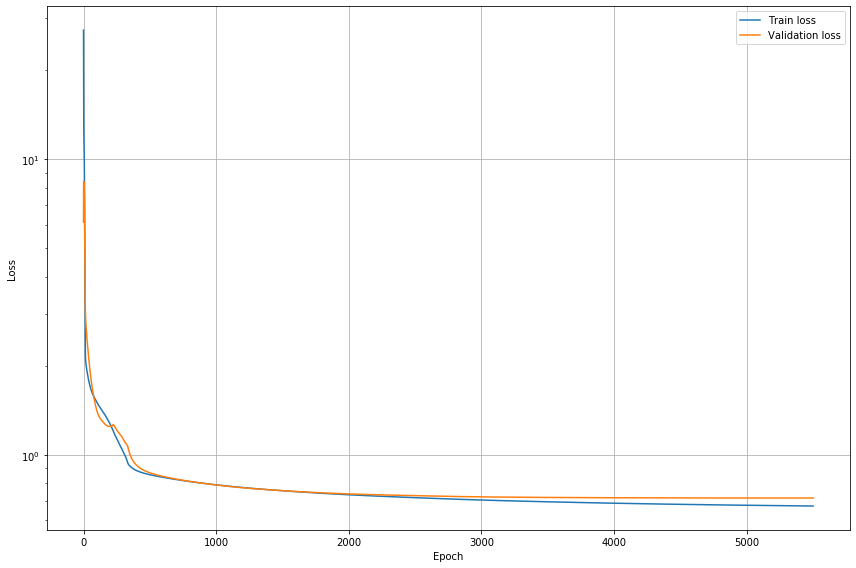

Epoch 200 - lr: 0.00091 - Train loss: 1.22630 - Valitation loss: 1.45730
Epoch 400 - lr: 0.00083 - Train loss: 1.11305 - Valitation loss: 1.08091
Epoch 600 - lr: 0.00076 - Train loss: 1.05160 - Valitation loss: 0.89949
Epoch 800 - lr: 0.00069 - Train loss: 1.00846 - Valitation loss: 0.78557
Epoch 1000 - lr: 0.00063 - Train loss: 0.98021 - Valitation loss: 0.72760
Epoch 1200 - lr: 0.00058 - Train loss: 0.96003 - Valitation loss: 0.70169
Epoch 1400 - lr: 0.00052 - Train loss: 0.94344 - Valitation loss: 0.68828
Epoch 1600 - lr: 0.00048 - Train loss: 0.92798 - Valitation loss: 0.66932
Epoch 1800 - lr: 0.00044 - Train loss: 0.91026 - Valitation loss: 0.64370
Epoch 2000 - lr: 0.00040 - Train loss: 0.89585 - Valitation loss: 0.63737
Epoch 2200 - lr: 0.00036 - Train loss: 0.88251 - Valitation loss: 0.62548
Epoch 2400 - lr: 0.00033 - Train loss: 0.86894 - Valitation loss: 0.60273
Epoch 2600 - lr: 0.00030 - Train loss: 0.85174 - Valitation loss: 0.54217
Epoch 2800 - lr: 0.00028 - Train loss: 0.8

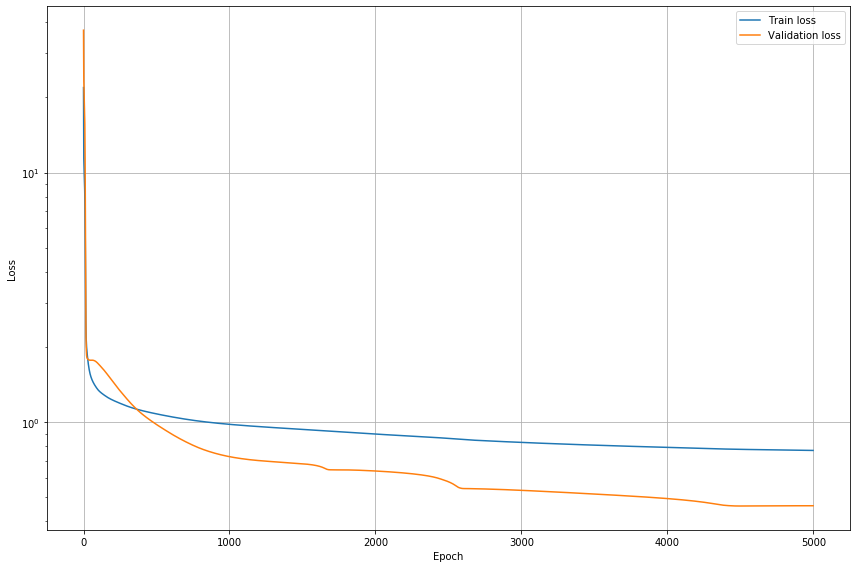

Epoch 200 - lr: 0.00091 - Train loss: 1.13116 - Valitation loss: 1.35281
Epoch 400 - lr: 0.00083 - Train loss: 0.92227 - Valitation loss: 1.17810
Epoch 600 - lr: 0.00076 - Train loss: 0.85410 - Valitation loss: 1.01581
Epoch 800 - lr: 0.00069 - Train loss: 0.83108 - Valitation loss: 0.92831
Epoch 1000 - lr: 0.00063 - Train loss: 0.81396 - Valitation loss: 0.88561
Epoch 1200 - lr: 0.00058 - Train loss: 0.79943 - Valitation loss: 0.85537
Epoch 1400 - lr: 0.00052 - Train loss: 0.78636 - Valitation loss: 0.83173
Epoch 1600 - lr: 0.00048 - Train loss: 0.77487 - Valitation loss: 0.81059
Epoch 1800 - lr: 0.00044 - Train loss: 0.76499 - Valitation loss: 0.79238
Epoch 2000 - lr: 0.00040 - Train loss: 0.75640 - Valitation loss: 0.77698
Epoch 2200 - lr: 0.00036 - Train loss: 0.74890 - Valitation loss: 0.76375
Epoch 2400 - lr: 0.00033 - Train loss: 0.74230 - Valitation loss: 0.75236
Epoch 2600 - lr: 0.00030 - Train loss: 0.73643 - Valitation loss: 0.74252
Epoch 2800 - lr: 0.00028 - Train loss: 0.7

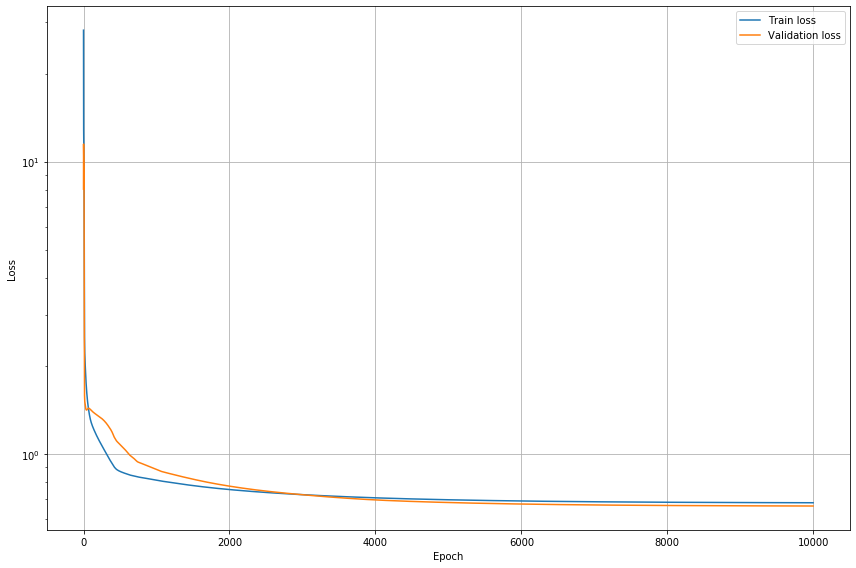

Epoch 200 - lr: 0.00091 - Train loss: 1.30957 - Valitation loss: 1.07886
Epoch 400 - lr: 0.00083 - Train loss: 1.13810 - Valitation loss: 0.98096
Epoch 600 - lr: 0.00076 - Train loss: 1.03645 - Valitation loss: 0.91180
Epoch 800 - lr: 0.00069 - Train loss: 0.98289 - Valitation loss: 0.86637
Epoch 1000 - lr: 0.00063 - Train loss: 0.94525 - Valitation loss: 0.83749
Epoch 1200 - lr: 0.00058 - Train loss: 0.91204 - Valitation loss: 0.81387
Epoch 1400 - lr: 0.00052 - Train loss: 0.88374 - Valitation loss: 0.79464
Epoch 1600 - lr: 0.00048 - Train loss: 0.85702 - Valitation loss: 0.77793
Epoch 1800 - lr: 0.00044 - Train loss: 0.83077 - Valitation loss: 0.76199
Epoch 2000 - lr: 0.00040 - Train loss: 0.80570 - Valitation loss: 0.74414
Epoch 2200 - lr: 0.00036 - Train loss: 0.78899 - Valitation loss: 0.73292
Epoch 2400 - lr: 0.00033 - Train loss: 0.77416 - Valitation loss: 0.72428
Epoch 2600 - lr: 0.00030 - Train loss: 0.76158 - Valitation loss: 0.71653
Epoch 2800 - lr: 0.00028 - Train loss: 0.7

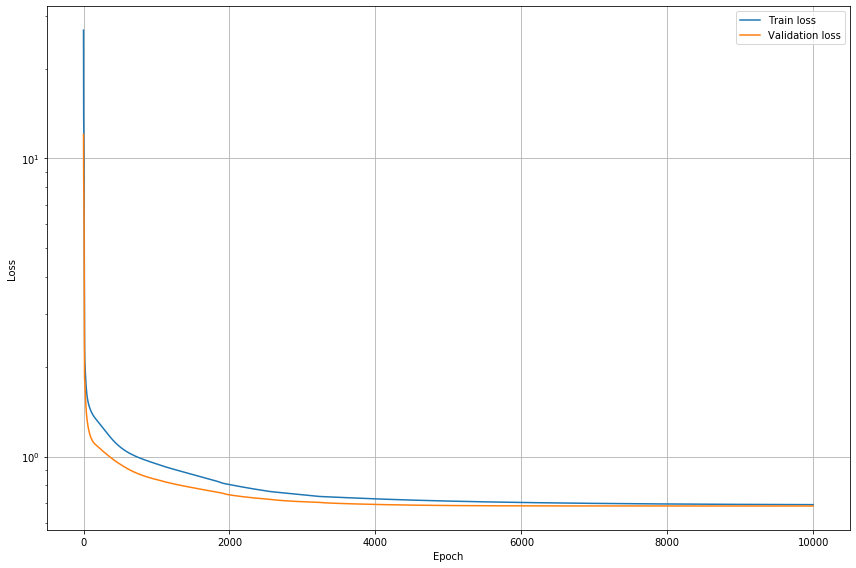


Parameters:
Nh1,Nh2: 200 200
Activation function: ELU
Regularizer: l2 	Coefficient: 0.01

Epoch 200 - lr: 0.00091 - Train loss: 1.12993 - Valitation loss: 1.24637
Epoch 400 - lr: 0.00083 - Train loss: 0.98376 - Valitation loss: 1.18285
Epoch 600 - lr: 0.00076 - Train loss: 0.90035 - Valitation loss: 1.15094
Epoch 800 - lr: 0.00069 - Train loss: 0.85243 - Valitation loss: 1.13393
Epoch 1000 - lr: 0.00063 - Train loss: 0.81919 - Valitation loss: 1.12716
Epoch 1200 - lr: 0.00058 - Train loss: 0.79039 - Valitation loss: 1.12212
Epoch 1400 - lr: 0.00052 - Train loss: 0.77102 - Valitation loss: 1.11480
Epoch 1600 - lr: 0.00048 - Train loss: 0.75327 - Valitation loss: 1.10818
Epoch 1800 - lr: 0.00044 - Train loss: 0.73597 - Valitation loss: 1.10295
Epoch 2000 - lr: 0.00040 - Train loss: 0.70834 - Valitation loss: 1.11550
Epoch 2200 - lr: 0.00036 - Train loss: 0.70231 - Valitation loss: 1.11944
Epoch 2400 - lr: 0.00033 - Train loss: 0.69556 - Valitation loss: 1.11139
Epoch 2600 - lr: 0.00030 

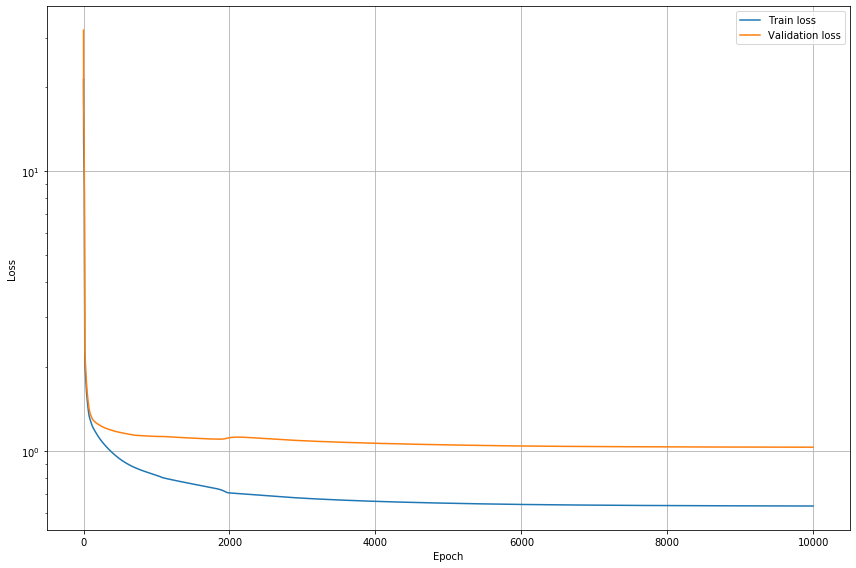

Epoch 200 - lr: 0.00091 - Train loss: 1.32397 - Valitation loss: 1.35083
Epoch 400 - lr: 0.00083 - Train loss: 1.06807 - Valitation loss: 1.11507
Epoch 600 - lr: 0.00076 - Train loss: 0.82918 - Valitation loss: 0.93500
Epoch 800 - lr: 0.00069 - Train loss: 0.76808 - Valitation loss: 0.93125
Epoch 1000 - lr: 0.00063 - Train loss: 0.73805 - Valitation loss: 0.93596
Epoch 1200 - lr: 0.00058 - Train loss: 0.71833 - Valitation loss: 0.93973
Epoch 1400 - lr: 0.00052 - Train loss: 0.70372 - Valitation loss: 0.94240
Epoch 1600 - lr: 0.00048 - Train loss: 0.69219 - Valitation loss: 0.94452
Epoch 1800 - lr: 0.00044 - Train loss: 0.68238 - Valitation loss: 0.94627
Epoch 2000 - lr: 0.00040 - Train loss: 0.67458 - Valitation loss: 0.94770
Epoch 2200 - lr: 0.00036 - Train loss: 0.66805 - Valitation loss: 0.94875
Epoch 2400 - lr: 0.00033 - Train loss: 0.66234 - Valitation loss: 0.94960
Epoch 2600 - lr: 0.00030 - Train loss: 0.65730 - Valitation loss: 0.95032
Epoch 2800 - lr: 0.00028 - Train loss: 0.6

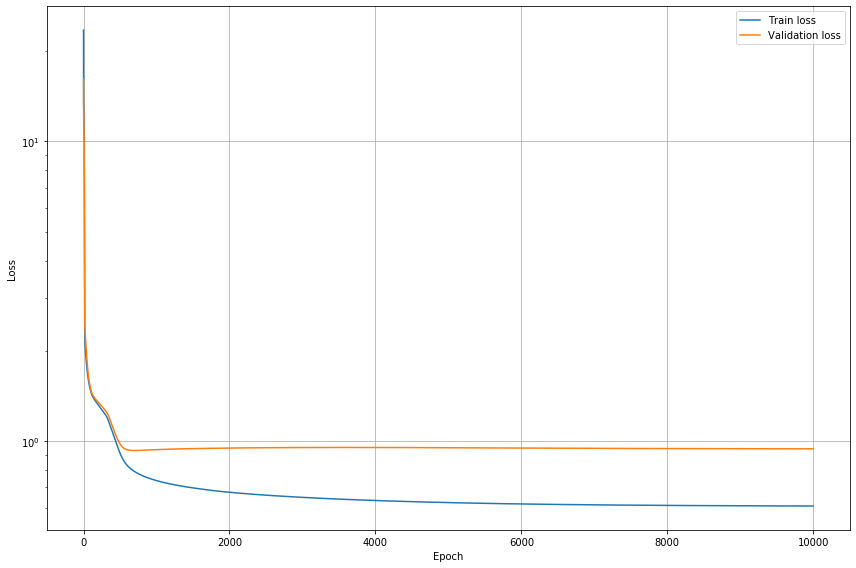

Epoch 200 - lr: 0.00091 - Train loss: 1.29853 - Valitation loss: 1.21246
Epoch 400 - lr: 0.00083 - Train loss: 1.11301 - Valitation loss: 1.17344
Epoch 600 - lr: 0.00076 - Train loss: 1.00694 - Valitation loss: 1.11859
Epoch 800 - lr: 0.00069 - Train loss: 0.94470 - Valitation loss: 1.07292
Epoch 1000 - lr: 0.00063 - Train loss: 0.90365 - Valitation loss: 1.03577
Epoch 1200 - lr: 0.00058 - Train loss: 0.85929 - Valitation loss: 0.97292
Epoch 1400 - lr: 0.00052 - Train loss: 0.82950 - Valitation loss: 0.94016
Epoch 1600 - lr: 0.00048 - Train loss: 0.80501 - Valitation loss: 0.91176
Epoch 1800 - lr: 0.00044 - Train loss: 0.78418 - Valitation loss: 0.88664
Epoch 2000 - lr: 0.00040 - Train loss: 0.76644 - Valitation loss: 0.86518
Epoch 2200 - lr: 0.00036 - Train loss: 0.75106 - Valitation loss: 0.84683
Epoch 2400 - lr: 0.00033 - Train loss: 0.73485 - Valitation loss: 0.82792
Epoch 2600 - lr: 0.00030 - Train loss: 0.71752 - Valitation loss: 0.77998
Epoch 2800 - lr: 0.00028 - Train loss: 0.7

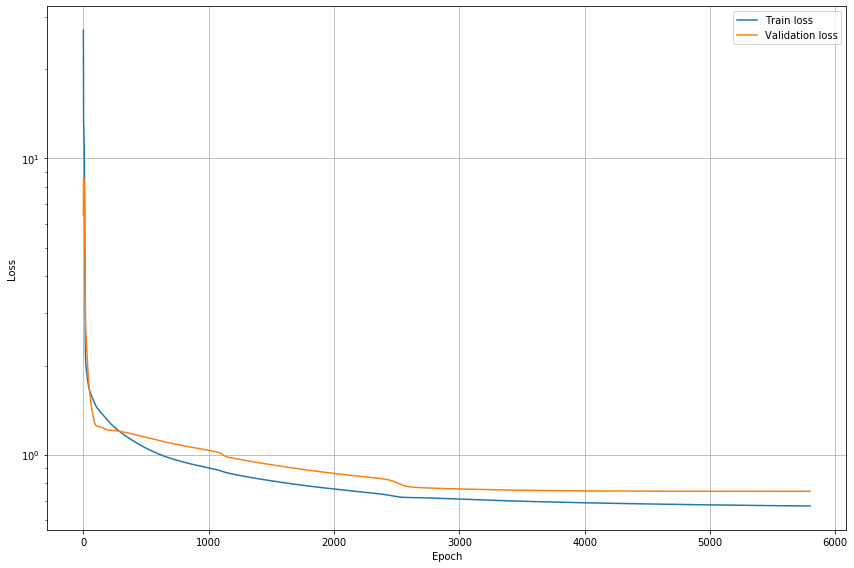

Epoch 200 - lr: 0.00091 - Train loss: 1.22527 - Valitation loss: 1.33810
Epoch 400 - lr: 0.00083 - Train loss: 1.15642 - Valitation loss: 1.16437
Epoch 600 - lr: 0.00076 - Train loss: 1.09643 - Valitation loss: 1.00520
Epoch 800 - lr: 0.00069 - Train loss: 1.05318 - Valitation loss: 0.90266
Epoch 1000 - lr: 0.00063 - Train loss: 1.01952 - Valitation loss: 0.83771
Epoch 1200 - lr: 0.00058 - Train loss: 0.98998 - Valitation loss: 0.79114
Epoch 1400 - lr: 0.00052 - Train loss: 0.96587 - Valitation loss: 0.75983
Epoch 1600 - lr: 0.00048 - Train loss: 0.94678 - Valitation loss: 0.74191
Epoch 1800 - lr: 0.00044 - Train loss: 0.93143 - Valitation loss: 0.73300
Epoch 2000 - lr: 0.00040 - Train loss: 0.91872 - Valitation loss: 0.72995
Epoch 2200 - lr: 0.00036 - Train loss: 0.90778 - Valitation loss: 0.72937
Epoch 2400 - lr: 0.00033 - Train loss: 0.89819 - Valitation loss: 0.72942
Epoch 2600 - lr: 0.00030 - Train loss: 0.88906 - Valitation loss: 0.72395
Epoch 2800 - lr: 0.00028 - Train loss: 0.8

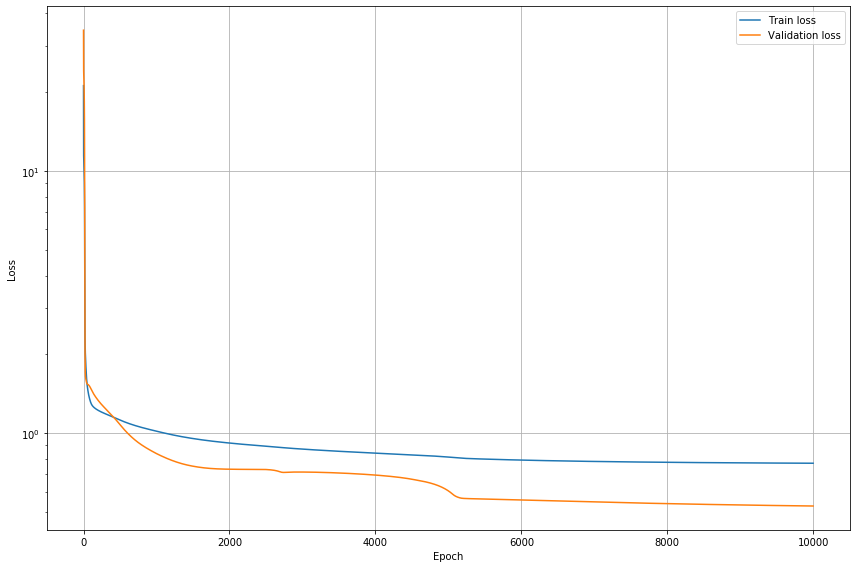

Epoch 200 - lr: 0.00091 - Train loss: 1.25200 - Valitation loss: 1.41143
Epoch 400 - lr: 0.00083 - Train loss: 1.13097 - Valitation loss: 1.37440
Epoch 600 - lr: 0.00076 - Train loss: 1.03094 - Valitation loss: 1.34315
Epoch 800 - lr: 0.00069 - Train loss: 0.96996 - Valitation loss: 1.28329
Epoch 1000 - lr: 0.00063 - Train loss: 0.93009 - Valitation loss: 1.22507
Epoch 1200 - lr: 0.00058 - Train loss: 0.90242 - Valitation loss: 1.17598
Epoch 1400 - lr: 0.00052 - Train loss: 0.88138 - Valitation loss: 1.13362
Epoch 1600 - lr: 0.00048 - Train loss: 0.86230 - Valitation loss: 1.09258
Epoch 1800 - lr: 0.00044 - Train loss: 0.84356 - Valitation loss: 1.05371
Epoch 2000 - lr: 0.00040 - Train loss: 0.82685 - Valitation loss: 1.01982
Epoch 2200 - lr: 0.00036 - Train loss: 0.81478 - Valitation loss: 0.99923
Epoch 2400 - lr: 0.00033 - Train loss: 0.80521 - Valitation loss: 0.98218
Epoch 2600 - lr: 0.00030 - Train loss: 0.79684 - Valitation loss: 0.96645
Epoch 2800 - lr: 0.00028 - Train loss: 0.7

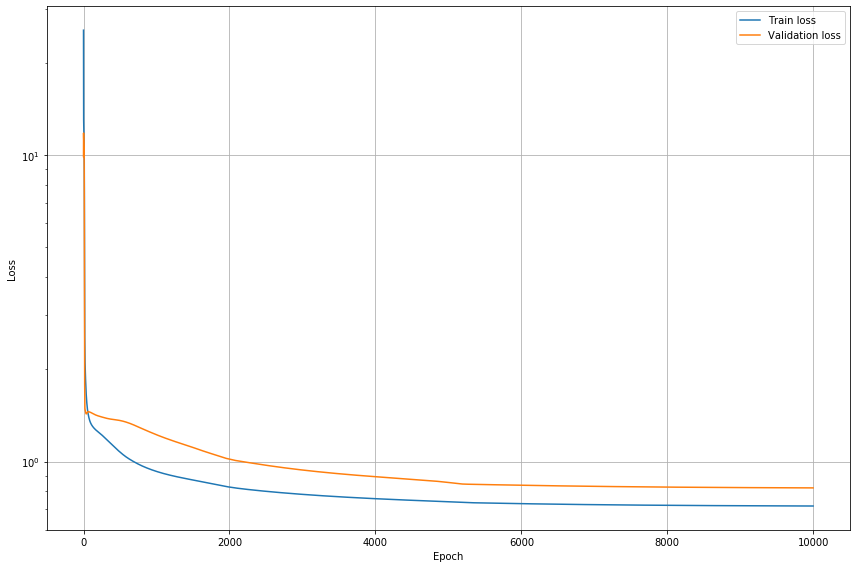

Epoch 200 - lr: 0.00091 - Train loss: 1.28139 - Valitation loss: 1.05827
Epoch 400 - lr: 0.00083 - Train loss: 1.12538 - Valitation loss: 0.97729
Epoch 600 - lr: 0.00076 - Train loss: 1.03390 - Valitation loss: 0.91173
Epoch 800 - lr: 0.00069 - Train loss: 0.98312 - Valitation loss: 0.86805
Epoch 1000 - lr: 0.00063 - Train loss: 0.95200 - Valitation loss: 0.84308
Epoch 1200 - lr: 0.00058 - Train loss: 0.92777 - Valitation loss: 0.82671
Epoch 1400 - lr: 0.00052 - Train loss: 0.89727 - Valitation loss: 0.81099
Epoch 1600 - lr: 0.00048 - Train loss: 0.86541 - Valitation loss: 0.78787
Epoch 1800 - lr: 0.00044 - Train loss: 0.84517 - Valitation loss: 0.77376
Epoch 2000 - lr: 0.00040 - Train loss: 0.82783 - Valitation loss: 0.76226
Epoch 2200 - lr: 0.00036 - Train loss: 0.81279 - Valitation loss: 0.75212
Epoch 2400 - lr: 0.00033 - Train loss: 0.79975 - Valitation loss: 0.74328
Epoch 2600 - lr: 0.00030 - Train loss: 0.78849 - Valitation loss: 0.73567
Epoch 2800 - lr: 0.00028 - Train loss: 0.7

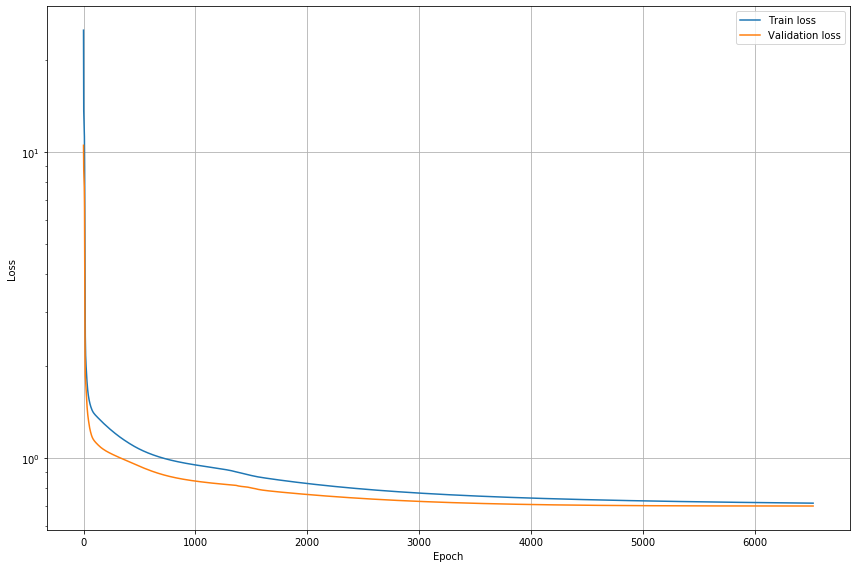

In [21]:
# Doing cross validation

#%% TRAINING PARAMETERS
min_epochs = 5000
num_epochs = 10000
lr = 0.001
en_decay = True
lr_final = 0.00001
lr_decay = (lr_final / lr)**(1 / num_epochs)
regul = "l2"
lambda_regul = 0.01

NN_act_f = ELU
NN_d_act_f = d_ELU

# Conventionally not training on a grid but using same number of neurons
for Nh1,Nh2 in zip(Nh1_list,Nh2_list):

    valid_losses = []

    print("\nParameters:")
    print("Nh1,Nh2:", Nh1, Nh2)
    print("Activation function:", NN_act_f.__name__)
    print("Regularizer:", regul, "\tCoefficient:", lambda_regul, end="\n\n")

    for ind_set in range(len(x_train_sets)):
        # Defining the NN
        #net = Network(Ni, Nh1, Nh2, No, NN_act_f, NN_d_act_f)
        net = Network_reg(Ni, Nh1, Nh2, No, NN_act_f, NN_d_act_f, regul, lambda_regul)
        
        # Preparing loss lists
        train_loss_log = []
        valid_loss_log = []

        # Refreshing learning rate
        lr = 0.001
        
        # Training NN on k-fold
        for num_ep in range(num_epochs):
            # Learning rate decay
            if en_decay:
                lr *= lr_decay
            # Train single epoch (sample by sample, no batch for now)
            train_loss_vec = [net.update(x, y, lr) for x, y in zip(x_train_sets[ind_set], y_train_sets[ind_set])]
            avg_train_loss = np.mean(train_loss_vec)
            # Test network
            y_valid_est = np.array([net.forward(x) for x in x_valid_sets[ind_set]])
            avg_valid_loss = np.mean((y_valid_est - y_valid_sets[ind_set])**2/2)
            
            # Log (using validation error list for early stopping)
            train_loss_log.append(avg_train_loss)
            valid_loss_log.append(avg_valid_loss)

            # Trying a condition for early stopping
            if ( (len(valid_loss_log)>=min_epochs) and (valid_loss_log[-1]>valid_loss_log[-2]) ):
                print("\nEARLY STOPPING:")
                print('Epoch %d - lr: %.5f - Train loss: %.5f - Valitation loss: %.5f' % (num_ep + 1, lr, avg_train_loss, avg_valid_loss), end="\n\n")
                break

            if (num_ep%200 == 199):
                print('Epoch %d - lr: %.5f - Train loss: %.5f - Valitation loss: %.5f' % (num_ep + 1, lr, avg_train_loss, avg_valid_loss))


        errors_dictio[str(NN_act_f.__name__)+str(Nh1)+str(Nh2)+regul+str(2*lambda_regul)+"valid"+str(ind_set)] = valid_loss_log[-2]

        valid_losses.append(valid_loss_log[-1])
        
        # Plot losses
        plt.close('all')
        plt.figure(figsize=(12,8))
        plt.semilogy(train_loss_log, label='Train loss')
        plt.semilogy(valid_loss_log, label='Validation loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid()
        plt.legend()
        plt.tight_layout()
        plt.show()

    temp_val_loss = np.mean(valid_losses)

    if (best_error == None or temp_val_loss < best_error):
        best_error = temp_val_loss
        NN_act_f_best = NN_act_f
        Nh1_best = Nh1
        Nh2_best = Nh2

In [22]:
print(best_error)
print(NN_act_f_best)
print(Nh1_best)
print(Nh2_best)

0.6459823792653834
<function ReLU at 0x7f5e5e211268>
50
50


In [23]:
errors_dictio

{'expit5050l20.02valid0': 2.4444197493056516,
 'expit5050l20.02valid1': 1.620443676598492,
 'expit5050l20.02valid2': 1.0785823462150093,
 'expit5050l20.02valid3': 4.821342904448395,
 'expit5050l20.02valid4': 1.5179142450823804,
 'expit5050l20.02valid5': 2.011067222350301,
 'expit100100l20.02valid0': 2.328962792146696,
 'expit100100l20.02valid1': 1.8813379328318944,
 'expit100100l20.02valid2': 1.8587367564828816,
 'expit100100l20.02valid3': 4.973225424278272,
 'expit100100l20.02valid4': 2.582980478650188,
 'expit100100l20.02valid5': 2.017698511137269,
 'expit200200l20.02valid0': 27.103824752995724,
 'expit200200l20.02valid1': nan,
 'expit200200l20.02valid2': 11.353404424172613,
 'expit200200l20.02valid3': 24.74219685371748,
 'expit200200l20.02valid4': 10.912804711398778,
 'expit200200l20.02valid5': 10.244082583974361,
 'ReLU5050l20.02valid0': 1.1367005192137354,
 'ReLU5050l20.02valid1': 0.9047893050526463,
 'ReLU5050l20.02valid2': 0.719509803462796,
 'ReLU5050l20.02valid3': 0.4392245462

In [26]:
errors_dictio = {'expit5050l20.02valid0': 2.4444197493056516,
 'expit5050l20.02valid1': 1.620443676598492,
 'expit5050l20.02valid2': 1.0785823462150093,
 'expit5050l20.02valid3': 4.821342904448395,
 'expit5050l20.02valid4': 1.5179142450823804,
 'expit5050l20.02valid5': 2.011067222350301,
 'expit100100l20.02valid0': 2.328962792146696,
 'expit100100l20.02valid1': 1.8813379328318944,
 'expit100100l20.02valid2': 1.8587367564828816,
 'expit100100l20.02valid3': 4.973225424278272,
 'expit100100l20.02valid4': 2.582980478650188,
 'expit100100l20.02valid5': 2.017698511137269,
 'expit200200l20.02valid0': 27.103824752995724,
 'expit200200l20.02valid1': np.nan,
 'expit200200l20.02valid2': 11.353404424172613,
 'expit200200l20.02valid3': 24.74219685371748,
 'expit200200l20.02valid4': 10.912804711398778,
 'expit200200l20.02valid5': 10.244082583974361,
 'ReLU5050l20.02valid0': 1.1367005192137354,
 'ReLU5050l20.02valid1': 0.9047893050526463,
 'ReLU5050l20.02valid2': 0.719509803462796,
 'ReLU5050l20.02valid3': 0.43922454625336693,
 'ReLU5050l20.02valid4': 0.7554850121115801,
 'ReLU5050l20.02valid5': 0.6459365440742475,
 'ReLU100100l20.02valid0': 1.0912506971391507,
 'ReLU100100l20.02valid1': 0.9064988852349918,
 'ReLU100100l20.02valid2': 0.7432408503858001,
 'ReLU100100l20.02valid3': 0.4737286792318346,
 'ReLU100100l20.02valid4': 0.716414725636245,
 'ReLU100100l20.02valid5': 0.637548208677036,
 'ReLU200200l20.02valid0': 1.1292567487827643,
 'ReLU200200l20.02valid1': 0.9064518617476244,
 'ReLU200200l20.02valid2': 0.7362537105191447,
 'ReLU200200l20.02valid3': 0.4590001334785079,
 'ReLU200200l20.02valid4': 0.7203427278565417,
 'ReLU200200l20.02valid5': 0.6278132985230475,
 'ELU5050l20.02valid0': 1.0458942156987456,
 'ELU5050l20.02valid1': 0.9498917848859056,
 'ELU5050l20.02valid2': 0.7233828400516489,
 'ELU5050l20.02valid3': 0.40593152846976743,
 'ELU5050l20.02valid4': 0.7187966985067019,
 'ELU5050l20.02valid5': 0.6612094199774161,
 'ELU100100l20.02valid0': 1.0673023437294915,
 'ELU100100l20.02valid1': 0.9395111470324702,
 'ELU100100l20.02valid2': 0.7145094355047744,
 'ELU100100l20.02valid3': 0.46252003734200364,
 'ELU100100l20.02valid4': 0.6644262608822713,
 'ELU100100l20.02valid5': 0.6827432594527116,
 'ELU200200l20.02valid0': 1.031718436519798,
 'ELU200200l20.02valid1': 0.9420035488714044,
 'ELU200200l20.02valid2': 0.7527055042731405,
 'ELU200200l20.02valid3': 0.5283684082817134,
 'ELU200200l20.02valid4': 0.8217166088765795,
 'ELU200200l20.02valid5': 0.6989632940380262}

Checking the best NN manually

In [29]:
avg_err_sigm = {"5050":0, "100100":0, "200200":0}
avg_err_ReLU = {"5050":0, "100100":0, "200200":0}
avg_err_ELU = {"5050":0, "100100":0, "200200":0}

for kk,vv in zip(errors_dictio.keys(), errors_dictio.values()):
    if (vv!=np.nan):
        if "expit5050" in kk:
            avg_err_sigm["5050"] += vv
        if "expit100100" in kk:
            avg_err_sigm["100100"] += vv
        if "expit200200" in kk:
            avg_err_sigm["200200"] += vv

        if "ReLU5050" in kk:
            avg_err_ReLU["5050"] += vv
        if "ReLU100100" in kk:
            avg_err_ReLU["100100"] += vv
        if "ReLU200200" in kk:
            avg_err_ReLU["200200"] += vv

        if "ELU5050" in kk:
            avg_err_ELU["5050"] += vv
        if "ELU100100" in kk:
            avg_err_ELU["100100"] += vv
        if "ELU200200" in kk:
            avg_err_ELU["200200"] += vv


# sigm200200 has one "nan" value... dividing by 5 instead of 6

avg_err_sigm["5050"] /= 6.
avg_err_sigm["100100"] /= 6.
avg_err_sigm["200200"] /= 5.

avg_err_ReLU["5050"] /= 6.
avg_err_ReLU["100100"] /= 6.
avg_err_ReLU["200200"] /= 6.

avg_err_ELU["5050"] /= 6.
avg_err_ELU["100100"] /= 6.
avg_err_ELU["200200"] /= 6.

print("Sigm:", avg_err_sigm)
print("ReLU:", avg_err_ReLU)
print("ELU:", avg_err_ELU)

Sigm: {'5050': 2.2489616906667047, '100100': 2.607156982587867, '200200': nan}
ReLU: {'5050': 0.766940955028062, '100100': 0.7614470077175097, '200200': 0.763186413484605}
ELU: {'5050': 0.750851081265031, '100100': 0.7551687473239538, '200200': 0.7959126334767769}


### Note on the errors

Looking at the errors, the best network seems to be ELU5050.

Now, let's train it.

# Re-training the best NN (using whole train set)

Re-training **ELU5050**

The train strategy is to train the network on the whole train set (without early stopping due to the lack of a validation set) for 3k epochs (a small number to try to avoid overfitting).

In [9]:
# Code...

#%% TRAINING PARAMETERS
min_epochs = 5000
num_epochs = 3000
lr = 0.001
en_decay = True
lr_final = 0.00001
lr_decay = (lr_final / lr)**(1 / num_epochs)
regul = "l2"
lambda_regul = 0.01

NN_act_f = ELU
NN_d_act_f = d_ELU

Ni = 1
Nh1 = 50
Nh2 = 50
No = 1

test_losses = []

print("\nParameters:")
print("Nh1,Nh2:", Nh1, Nh2)
print("Activation function:", NN_act_f.__name__, "\n")
print("Regularizer:", regul, "\tCoefficient:", lambda_regul, end="\n\n")

# Defining the NN
net = Network_reg(Ni, Nh1, Nh2, No, NN_act_f, NN_d_act_f, regul, lambda_regul)

# Preparing loss lists
train_loss_log = []
test_loss_log = []

# Refreshing learning rate
lr = 0.001


for num_ep in range(num_epochs):
    # Learning rate decay
    if en_decay:
        lr *= lr_decay
    # Train single epoch (sample by sample, no batch for now)
    train_loss_vec = [net.update(x, y, lr) for x, y in zip(x_train, y_train)]
    avg_train_loss = np.mean(train_loss_vec)
    # Test network
    y_test_est = np.array([net.forward(x) for x in x_test])
    avg_test_loss = np.mean((y_test_est - y_test)**2/2)

    # Log (using validation error list for early stopping)
    train_loss_log.append(avg_train_loss)
    test_loss_log.append(avg_test_loss)

    if (num_ep%200 == 199):
        print('Epoch %d - lr: %.5f - Train loss: %.5f - Test loss: %.5f' % (num_ep + 1, lr, avg_train_loss, avg_test_loss))

    test_losses.append(test_loss_log[-1])


Parameters:
Nh1,Nh2: 50 50
Activation function: ELU 

Regularizer: l2 	Coefficient: 0.01

Epoch 200 - lr: 0.00074 - Train loss: 0.97111 - Test loss: 0.99924
Epoch 400 - lr: 0.00054 - Train loss: 0.80771 - Test loss: 0.81453
Epoch 600 - lr: 0.00040 - Train loss: 0.75959 - Test loss: 0.76931
Epoch 800 - lr: 0.00029 - Train loss: 0.73376 - Test loss: 0.75071
Epoch 1000 - lr: 0.00022 - Train loss: 0.71690 - Test loss: 0.74313
Epoch 1200 - lr: 0.00016 - Train loss: 0.70521 - Test loss: 0.74136
Epoch 1400 - lr: 0.00012 - Train loss: 0.69684 - Test loss: 0.74265
Epoch 1600 - lr: 0.00009 - Train loss: 0.69076 - Test loss: 0.74536
Epoch 1800 - lr: 0.00006 - Train loss: 0.68631 - Test loss: 0.74848
Epoch 2000 - lr: 0.00005 - Train loss: 0.68306 - Test loss: 0.75143
Epoch 2200 - lr: 0.00003 - Train loss: 0.68068 - Test loss: 0.75398
Epoch 2400 - lr: 0.00003 - Train loss: 0.67893 - Test loss: 0.75607
Epoch 2600 - lr: 0.00002 - Train loss: 0.67765 - Test loss: 0.75772
Epoch 2800 - lr: 0.00001 - Tr

### Plotting results

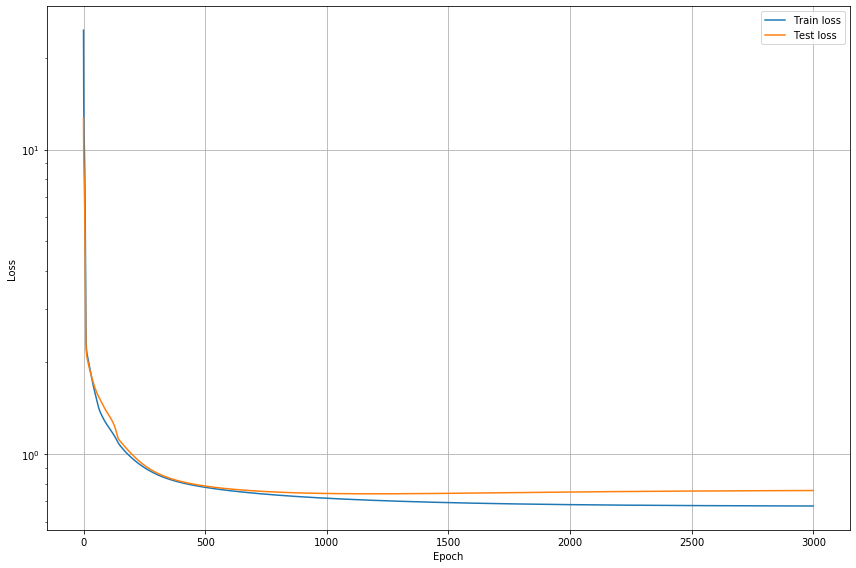

In [10]:
# Plot losses
plt.close('all')
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(test_loss_log, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

### After training

No handles with labels found to put in legend.


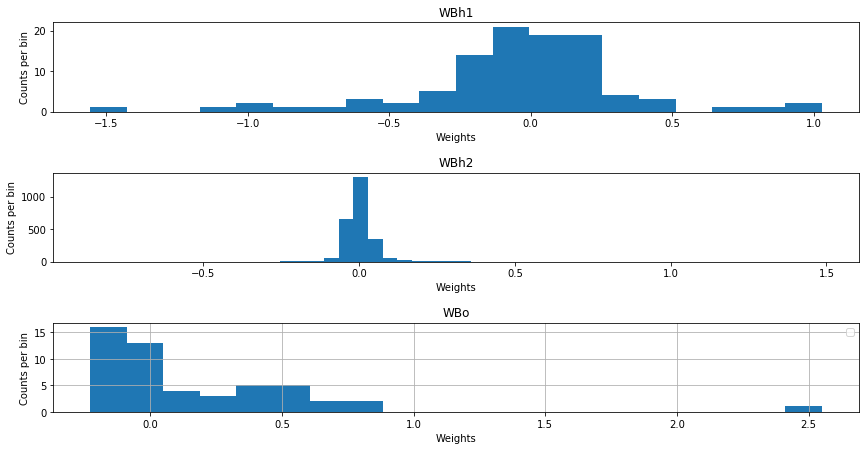

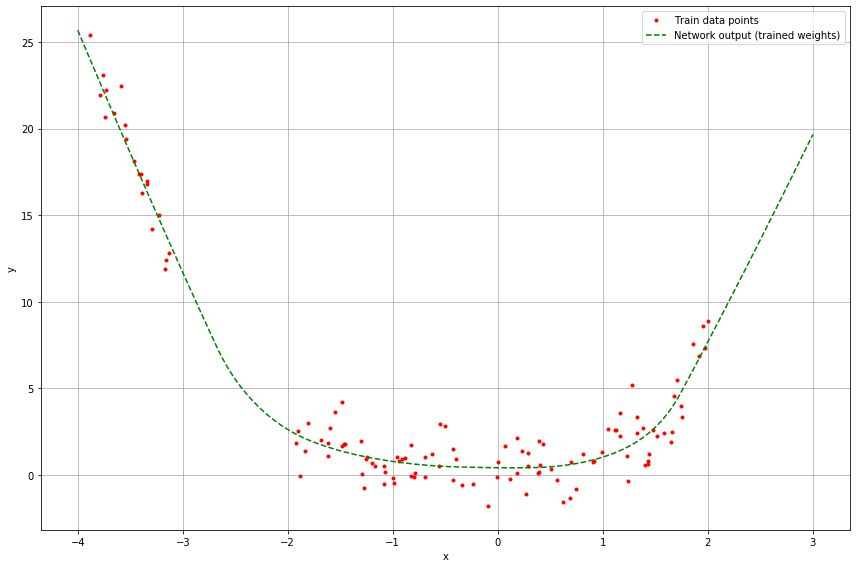

In [11]:
# Plot weights after training
net.plot_weights()


#%% FORWARD PASS (after training)
x_highres = np.linspace(-4,3,1001)
net_output = np.array([net.forward(x) for x in x_highres])

### Plot
plt.close('all')
plt.figure(figsize=(12,8))
#plt.plot(x_highres, poly_model(x_highres, beta_true), color='b', ls='--', label='True data model')
plt.plot(x_train, y_train, color='r', ls='', marker='.', label='Train data points')
plt.plot(x_highres, net_output, color='g', ls='--', label='Network output (trained weights)')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

/home/tommaso/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  if sys.path[0] == '':
/home/tommaso/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  
/home/tommaso/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantl

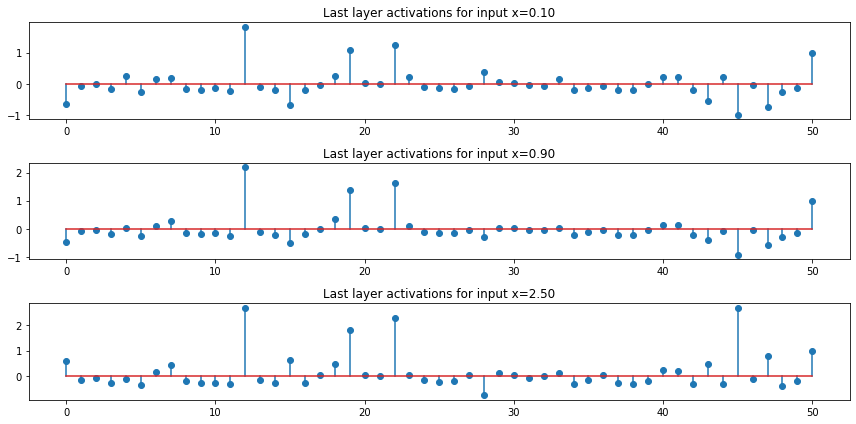

In [12]:
#%% Analyze actiovations

x1 = 0.1
y1, z1 = net.forward(x1, additional_out=True)
x2 = 0.9
y2, z2 = net.forward(x2, additional_out=True)
x3 = 2.5
y3, z3 = net.forward(x3, additional_out=True)


fig, axs = plt.subplots(3, 1, figsize=(12,6))
axs[0].stem(z1)
axs[0].set_title('Last layer activations for input x=%.2f' % x1)
axs[1].stem(z2)
axs[1].set_title('Last layer activations for input x=%.2f' % x2)
axs[2].stem(z3)
axs[2].set_title('Last layer activations for input x=%.2f' % x3)
plt.tight_layout()
plt.show()

## Saving weights

They will be loaded by the script which will estimate the $y$s on test set opening file: "test_set.txt"

In [13]:
np.save("WBo", net.WBo)
np.save("WBh1", net.WBh1)
np.save("WBh2", net.WBh2)